In [1]:
from __future__ import absolute_import, division, print_function
from tensorflow.keras.layers import Lambda, Dense, Input, Layer, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.initializers import Constant
from tensorflow.keras.backend import concatenate
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K


import gc
import argparse


In [3]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [20]:
# standard numerical library imports
import numpy as np
import math
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import rc
import os
import sys

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, to_categorical


In [5]:
sys.path.append('../20240503')
import DCTR


In [15]:
def get_rwgt(model_list, x1_plt, x1_nrm, batch_size = 5*8192):
    rwgt_list = np.empty(shape = (len(model_list),len(x1_plt)), dtype = np.float64)
    for i, model in enumerate(model_list):
        K.clear_session()
        dctr = tf.keras.models.load_model(model)
        with tf.device('/gpu:0'):
            preds = dctr.predict(x1_nrm, batch_size=batch_size)
        rwgt = np.divide(preds[:,0], preds[:,1])
        # set wgts of events with pt > 1000 to 1
        for k, _ in enumerate(rwgt):
            if (x1_plt[k,0]>1000):
                rwgt[k] = 1
        
        rwgt_list[i] = rwgt
        print(f'finished calculating weights for {i+1} models')
    K.clear_session()
    return rwgt_list


In [7]:
data_dir = '/tf/data/BachelorThesis_Data/Valentinas_Samples/test_samples_ready'


In [8]:
dataset=np.load(f'{data_dir}/X_Nom_TestAll_13TeV_test_plot.npz')
print(dataset.files)
X1_test=dataset['a']
X1_plot=dataset['b']

X1_plot_wgt = np.array([1. for i in range(X1_plot.shape[0])])

print(X1_test.shape)
print(X1_plot.shape)


['a', 'b']
(99951578, 2, 6)
(99951578, 8)


In [9]:
dataset=np.load(f'{data_dir}/X_Up_TestAll_13TeV_test_plot.npz')
print(dataset.files)
X0_test=dataset['a']
X0_plot=dataset['b']

X0_plot_wgt = np.array([1. for i in range(X0_plot.shape[0])])

print(X0_test.shape)
print(X0_plot.shape)


['a', 'b']
(99951578, 2, 6)
(99951578, 8)


In [10]:
model_dir = '/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/saved_models'
model_list = []

for i in range(1, 26):
    model_list.append(f'{model_dir}/DCTR_training_iter_{i:02d}.h5')

print(model_list)


['/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/saved_models/DCTR_training_iter_01.h5', '/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/saved_models/DCTR_training_iter_02.h5', '/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/saved_models/DCTR_training_iter_03.h5', '/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/saved_models/DCTR_training_iter_04.h5', '/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/saved_models/DCTR_training_iter_05.h5', '/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/saved_models/DCTR_training_iter_06.h5', '/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/saved_models/DCTR_training_iter_07.h5', '/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/saved_models/DCTR_training_iter_08.h5', '/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/saved_models/DCTR_training_iter_09.h5', '/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/saved_models/DCTR_training_iter_10.h5', '/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/saved_models/DCTR_training_

In [16]:
wgts_list = get_rwgt(model_list, X1_plot, X1_test, batch_size = 5*8192)

print(np.shape(wgts_list))


finished calculating weights for 1 models
finished calculating weights for 2 models
finished calculating weights for 3 models
finished calculating weights for 4 models
finished calculating weights for 5 models
finished calculating weights for 6 models
finished calculating weights for 7 models
finished calculating weights for 8 models
finished calculating weights for 9 models
finished calculating weights for 10 models
finished calculating weights for 11 models
finished calculating weights for 12 models
finished calculating weights for 13 models
finished calculating weights for 14 models
finished calculating weights for 15 models
finished calculating weights for 16 models
finished calculating weights for 17 models
finished calculating weights for 18 models
finished calculating weights for 19 models
finished calculating weights for 20 models
finished calculating weights for 21 models
finished calculating weights for 22 models
finished calculating weights for 23 models
finished calculating

In [18]:
wgts_mean_per_event = np.mean(wgts_list, axis = 0)
print(np.shape(wgts_mean_per_event))


(99951578,)


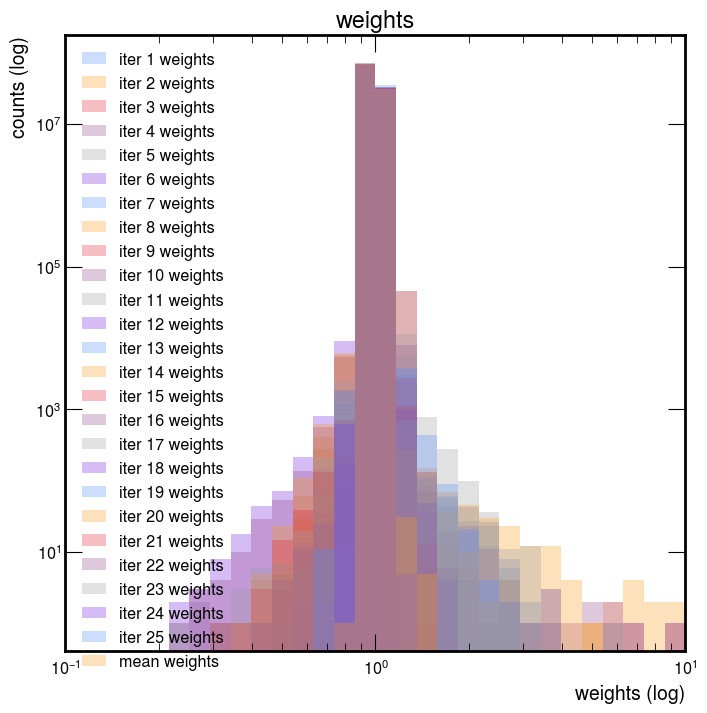

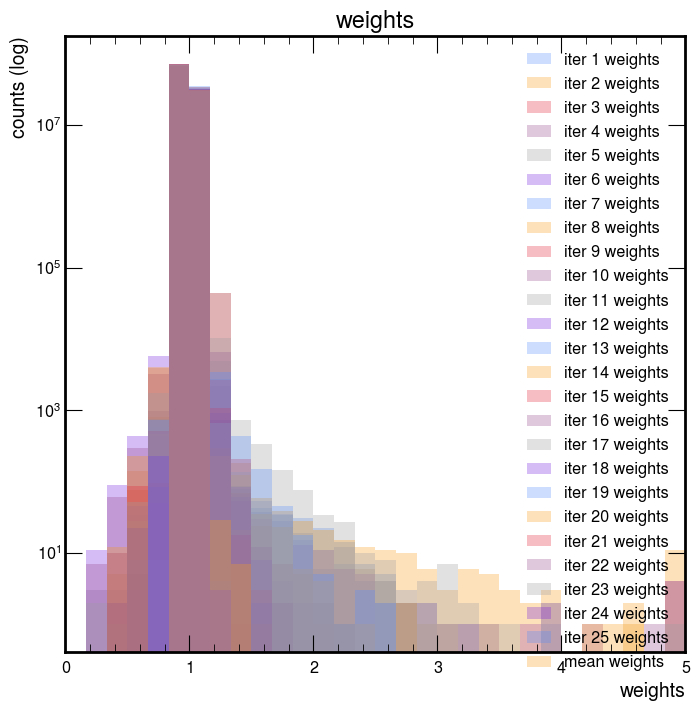

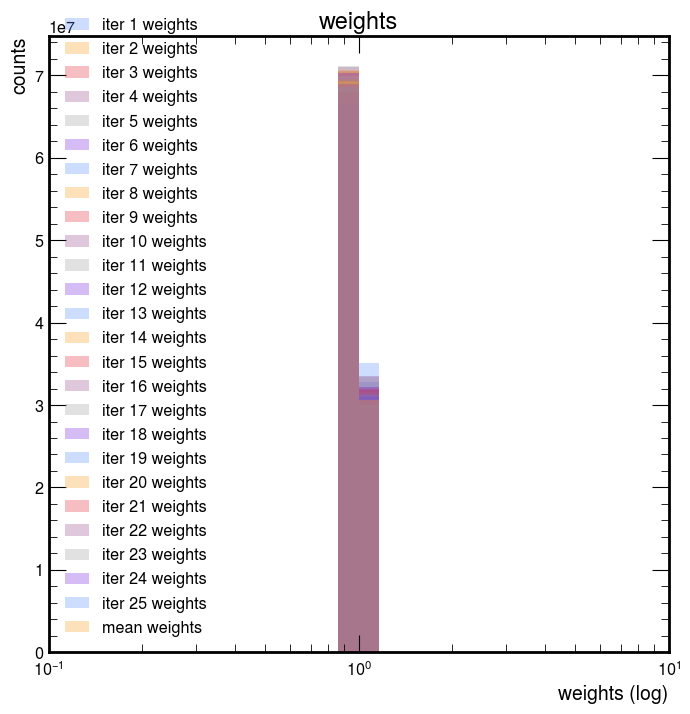

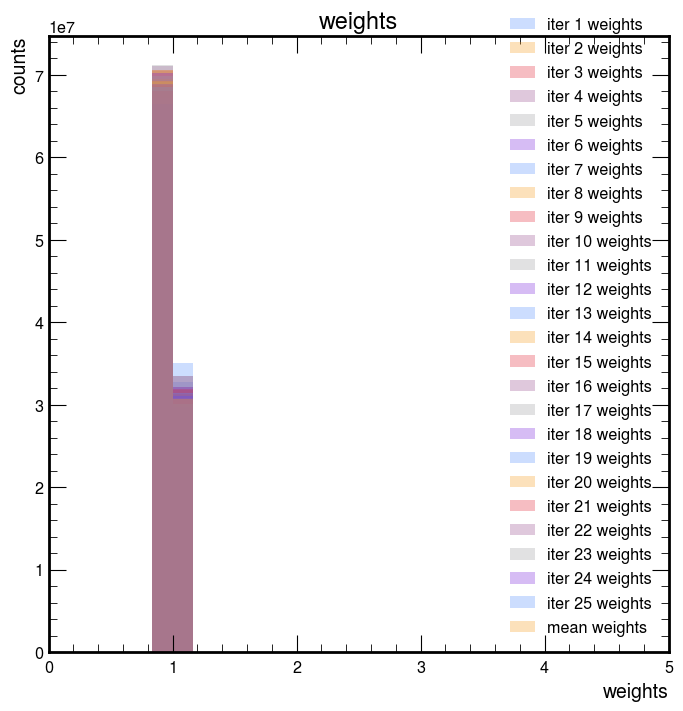

In [48]:
# plot and check dctr rwgt
font = {'size'   : 14}
rc('font', **font)

wgts_args = []
for i, _ in enumerate(wgts_list):
    wgts_args.append([wgts_list[i], rf'iter {i + 1} weights'])
wgts_args.append([wgts_mean_per_event, rf'mean weights'])

# y log scale
DCTR.plot_weights(wgts_args, start = 0.1, stop = 10) # log x
DCTR.plot_weights(wgts_args, start = 0, stop = 5, xscale='lin') # linear x

# y lin scale
DCTR.plot_weights(wgts_args, start = 0.1, stop = 10, yscale='lin') # log x
DCTR.plot_weights(wgts_args, start = 0, stop = 5, xscale='lin', yscale='lin') # linear x


In [23]:
# check weights

# when building ratio of square root of squared weights, the value we are comparing against has wgt = 1 for all events 
# -> /sqrt(num_events) is all we need

def get_wgts_stats(wgts_list):
    min_wgt_list    = []
    max_wgt_list    = []
    mean_wgt_list   = []
    ratio_wgts_list = []
    sqrt_num_events = math.sqrt(len(wgts_list[0]))
    for i, wgts in enumerate(wgts_list):
        min_wgt_list.append(np.min(wgts))
        max_wgt_list.append(np.max(wgts))
        mean_wgt_list.append(np.mean(wgts))
        
        sqrt_sum_wgts_squared = math.sqrt(np.sum(np.power(wgts, 2)))
        ratio_wgts_list.append(sqrt_num_events/sqrt_sum_wgts_squared)

    return np.array(min_wgt_list), np.array(max_wgt_list), np.array(mean_wgt_list), np.array(ratio_wgts_list)


In [24]:
min_wgt_list, max_wgt_list, mean_wgt_list, ratio_wgt_list = get_wgts_stats(wgts_list)
np.set_printoptions(precision=5, suppress=True)

print(f'{min_wgt_list   = }\n')
print(f'{max_wgt_list   = }\n')
print(f'{mean_wgt_list  = }\n')
print(f'{ratio_wgt_list = }\n')

mean_mean_wgt = np.mean(mean_wgt_list)
std_mean_wgt  = np.std(mean_wgt_list)

mean_ratio_wgt = np.mean(ratio_wgt_list)
std_ratio_wgt  = np.std(ratio_wgt_list)

print(f'mean weights:\n\
{mean_mean_wgt:.5f} +/- {std_mean_wgt:.5f}\n')

print(f'ratio of sqrt of sum of squared weights:\n\
{mean_ratio_wgt:.5f} +/- {std_ratio_wgt:.5f}')


min_wgt_list    = array([0.86665, 0.44253, 0.88157, 0.65418, 0.91105, 0.57602, 0.52073,
       0.48652, 0.86075, 0.62288, 0.26684, 0.22105, 0.56965, 0.82989,
       0.71768, 0.22705, 0.46637, 0.67877, 0.71364, 0.35745, 0.33961,
       0.40163, 0.21579, 0.78023, 0.70693])

max_wgt_list    = array([ 3.883  ,  2.1408 ,  1.27987,  8.66702,  1.22   ,  9.55826,
        2.94078,  4.66327,  1.42804,  1.1636 ,  2.88746,  1.66522,
        1.19754,  1.5365 ,  1.57986,  1.69593,  1.25233,  1.14417,
        1.18614, 11.12243,  1.46458,  1.5227 ,  5.87407,  1.17435,
        2.62022])

mean_wgt_list   = array([1.0033 , 0.99701, 0.99981, 0.99769, 0.99914, 1.00092, 1.00281,
       0.99803, 1.00156, 1.00257, 1.00081, 1.00139, 1.00064, 0.99759,
       1.00001, 0.99904, 1.0003 , 1.00148, 0.99848, 1.00164, 1.00197,
       1.00308, 0.99791, 0.99958, 1.00088])

ratio_wgt_list = array([0.99587, 1.00224, 0.99933, 1.00148, 1.00009, 0.99826, 0.99645,
       1.00109, 0.99774, 0.99656, 0.9984 , 0.9977 , 0.99853, 1

In [ ]:
# covariance calculations

In [27]:
# covariance matrix using weighted samples
def weighted_cov(data, weights):
    # print(f'{np.shape(data) = }')

    # Calculate weighted mean
    weighted_mean = np.average(data, axis=0, weights=weights)
    # print(f'{np.shape(weighted_mean) = }')
    # print(f'{weighted_mean = }')

    # Calculate centered data
    centered_data = data - weighted_mean
    # print(f'{np.shape(centered_data) = }')

    # Calculate weighted covariance matrix
    vars = len(data[0,:]) # num of variables per sample
    weighted_covariance = np.zeros(shape=(vars, vars))
    for i in range(vars):
        for j in range(vars):
            weighted_covariance[i, j] = np.sum(
                weights * centered_data[:,i] * centered_data[:,j]) / np.sum(weights)

    return weighted_covariance
    

# correlation matrix using weighted samples
def weighted_corr(data, weights):
    cov = weighted_cov(data, weights)

    # Calculate diagonal matrix for standard deviations
    std_dev = np.sqrt(np.diag(cov))
    std_dev_matrix = np.outer(std_dev, std_dev)

    # Calculate correlation matrix
    weighted_correlation = cov / std_dev_matrix

    return weighted_correlation
    


In [151]:
import matplotlib.patheffects as pe

def plot_matrix(matrix, title, vmin=None, vmax=None):
    font = {'size'   : 14}
    rc('font', **font)

    variable_labels = np.arange(1, len(matrix) + 1) # Labels for variables is bin number
    
    figsize = (max(8, (matrix.shape[1]+1)*0.9), max(7, matrix.shape[0])*0.9)
    plt.figure(figsize=figsize)
    
    if vmin is not None or vmax is not None:
        plt.matshow(matrix, cmap='viridis', vmin=vmin, vmax=vmax, fignum=1, aspect='auto')  # Set colormap limits if specified
    else:
        plt.matshow(matrix, cmap='viridis', fignum=1, aspect='auto')  # Default behavior with automatic colormap limits

    plt.colorbar()  # Add colorbar to show scale
    plt.title(title)  # Set the title of the plot
    
    # Add annotations to show values in the heatmap
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            plt.text(j, i, f'{matrix[i, j]:.3f}', ha='center', va='center', color='black',  path_effects=[pe.withStroke(linewidth=2, foreground="white")])

    # Label x-axis with variable names
    plt.xticks(ticks=np.arange(len(variable_labels)), labels=variable_labels)
    plt.xlabel('bin number')  # Label x-axis

    # Label y-axis with variable names
    plt.yticks(ticks=np.arange(len(variable_labels)), labels=variable_labels)
    plt.ylabel('bin number')  # Label y-axis

    plt.show()



In [66]:
hist_list = []
bins = np.linspace(0, 1000, 11)

for i, wgt in enumerate(wgts_list):
    hist, _ = np.histogram(X1_plot[:,0], weights = wgt, bins = bins)
    hist_list.append(hist)
    print(f'calculated hist for {i + 1} iterations')
    

calculated hist for 0 iterations
calculated hist for 1 iterations
calculated hist for 2 iterations
calculated hist for 3 iterations
calculated hist for 4 iterations
calculated hist for 5 iterations
calculated hist for 6 iterations
calculated hist for 7 iterations
calculated hist for 8 iterations
calculated hist for 9 iterations
calculated hist for 10 iterations
calculated hist for 11 iterations
calculated hist for 12 iterations
calculated hist for 13 iterations
calculated hist for 14 iterations
calculated hist for 15 iterations
calculated hist for 16 iterations
calculated hist for 17 iterations
calculated hist for 18 iterations
calculated hist for 19 iterations
calculated hist for 20 iterations
calculated hist for 21 iterations
calculated hist for 22 iterations
calculated hist for 23 iterations
calculated hist for 24 iterations


In [172]:
hist_list = np.array(hist_list)

print(hist_list.shape)
print(hist_list[::3])

mean_hist = np.mean(hist_list, axis = 0)
std_hist = np.std(hist_list, axis = 0)

print(mean_hist)
print(std_hist)

(25, 10)
[[81086787.626 13797292.684  3526263.386  1132005.057   420480.424
    170645.258    75611.378    35451.91     17395.76      8861.457]
 [80628779.827 13681646.76   3523592.331  1138333.892   423970.63
    172941.496    77082.198    36318.21     17891.707     9137.896]
 [81113108.125 13724434.763  3521860.142  1133155.357   421183.741
    170815.578    75572.574    35363.526    17315.955     8796.742]
 [80992529.931 13799483.442  3537292.357  1135699.287   422433.057
    171985.157    76373.249    35826.156    17572.984     8945.512]
 [80874119.604 13737815.084  3523893.345  1135255.848   422853.187
    172049.555    76289.528    35778.246    17560.804     8966.058]
 [80658842.341 13790667.975  3539216.869  1130362.17    418953.759
    170211.905    75517.633    35422.831    17366.267     8832.181]
 [80707286.145 13733160.265  3501763.28   1121625.142   417161.45
    170186.841    75843.621    35711.908    17584.142     8978.63 ]
 [80961027.975 13868371.071  3549951.18   113972

[[ 1.     0.186  0.22   0.222  0.274  0.271  0.251  0.225  0.196  0.166]
 [ 0.186  1.     0.506  0.14   0.042 -0.029 -0.062 -0.069 -0.07  -0.067]
 [ 0.22   0.506  1.     0.879  0.755  0.62   0.513  0.434  0.36   0.293]
 [ 0.222  0.14   0.879  1.     0.94   0.825  0.718  0.63   0.544  0.463]
 [ 0.274  0.042  0.755  0.94   1.     0.966  0.904  0.842  0.774  0.704]
 [ 0.271 -0.029  0.62   0.825  0.966  1.     0.983  0.949  0.901  0.845]
 [ 0.251 -0.062  0.513  0.718  0.904  0.983  1.     0.99   0.96   0.917]
 [ 0.225 -0.069  0.434  0.63   0.842  0.949  0.99   1.     0.989  0.962]
 [ 0.196 -0.07   0.36   0.544  0.774  0.901  0.96   0.989  1.     0.991]
 [ 0.166 -0.067  0.293  0.463  0.704  0.845  0.917  0.962  0.991  1.   ]]


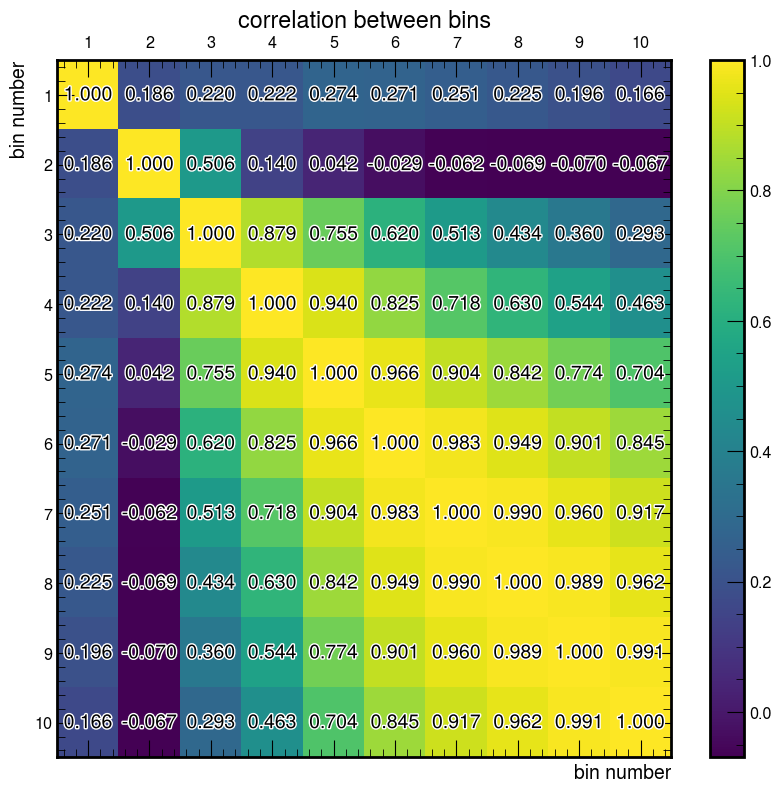

In [173]:
corr_matrix = weighted_corr(hist_list, [1]*len(hist_list))

np.set_printoptions(precision=3, suppress=True)
print(corr_matrix)

plot_matrix(corr_matrix, title = 'correlation between bins')



In [174]:
bins = np.linspace(0, 1000, 11)

target_hist, _ = np.histogram(X0_plot[:,0], bins=bins)
nominal_hist, _ = np.histogram(X1_plot[:,0], bins=bins)

# add last value to hist for plotting reasonscenter_mass_energy = '13 TeV'
target_hist = np.concatenate((target_hist, [target_hist[-1]]))
nominal_hist = np.concatenate((nominal_hist, [nominal_hist[-1]]))

mean_hist = np.concatenate((mean_hist, [mean_hist[-1]]))
std_hist = np.concatenate((std_hist, [std_hist[-1]]))



In [175]:
# plot 

Text(1.0, 1.05, '13 TeV')

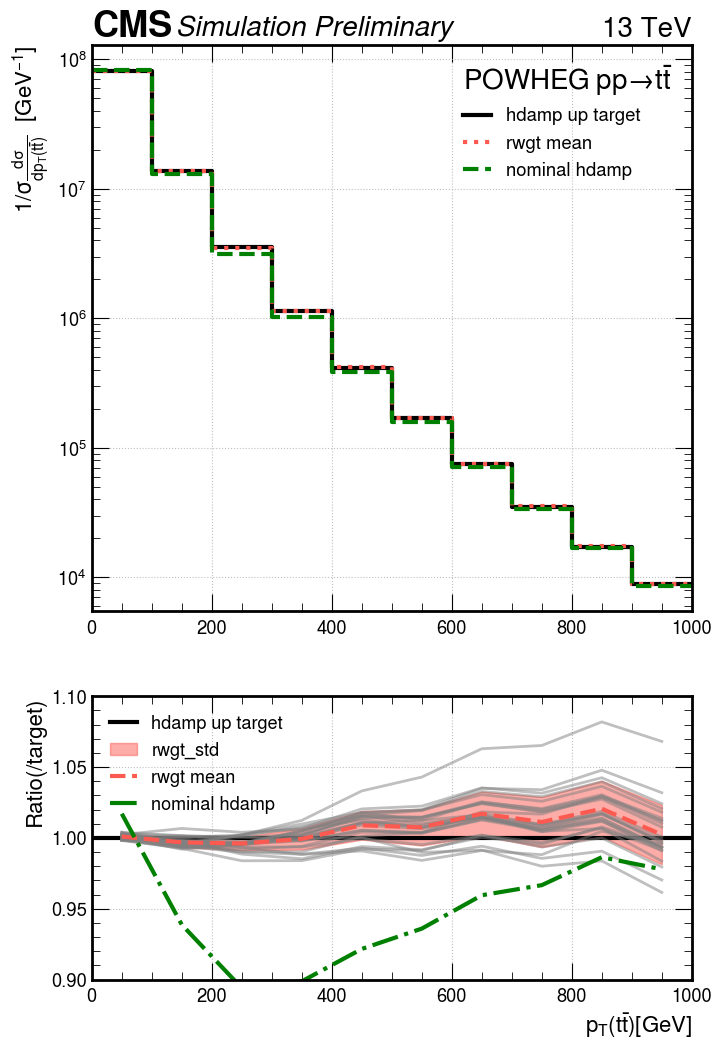

In [178]:
ratio_ylim = [0.90, 1.10]

import mplhep as hep
plt.style.use(hep.style.CMS)
plt_style_10a = {'color':'Green', 'linewidth':3, 'linestyle':'--'} #, 'density':True, 'histtype':'step'}
plt_style_11a = {'color':'black', 'linewidth':3, 'linestyle':'-'} #', 'density':True, 'histtype':'step'}
plt_style_12a = {'color':'#FC5A50', 'linewidth':3, 'linestyle':':'} #, 'density':True, 'histtype':'step'}

font = {'size'   : 16}
rc('font', **font)

# labels and titles
pythia_text = r'$POWHEG \; pp \to  t\bar{t}$'
hep_text = 'Simulation Preliminary'
def make_legend(ax, title):
    leg = ax.legend(frameon=False)
    leg.set_title(title, prop={'size':20})
    leg._legend_box.align = "left"
    plt.tight_layout()


# Create figure with two subplots
fig, axes = plt.subplots(nrows=2, figsize=(8,11), gridspec_kw={'height_ratios': [2, 1]})
fig.tight_layout(pad=1)

# First subplot
bin_centers = (bins[:-1] + bins[1:]) / 2.0

axes[0].step(bins, target_hist, label = 'hdamp up target', where='post', **plt_style_11a)
axes[0].step(bins, mean_hist, label = 'rwgt mean', where='post', **plt_style_12a)
axes[0].step(bins, nominal_hist, label = 'nominal hdamp', where='post', **plt_style_10a)

# Calculate the ratios of histograms
ratio_0 = target_hist / target_hist
ratio_1 = mean_hist / target_hist
ratio_std = std_hist / mean_hist
ratio_2 = nominal_hist / target_hist



make_legend(axes[0], pythia_text)
obs = r'p_{T}'
part = r't\bar{t}'
unit =r' [GeV]'
inv_unit = r' [GeV$^{-1}$]'
start = bins[0]
stop = bins[-1]

# Constructing the label using Python string formatting
label = r'$1$/$\sigma \frac{d\sigma}{d %s(%s)}$ %s' % (obs, part, inv_unit)

axes[0].set_ylabel(label)
axes[0].set_yscale('log')
axes[0].grid(True)

# Second subplot

axes[1].plot([start, stop], [1,1], '-', color='black',  linewidth=3, label='hdamp up target')
for hist in hist_list:
    axes[1].plot(bin_centers, hist/target_hist[:-1], linewidth=2, alpha = 0.5, color = 'grey')
axes[1].fill_between(bin_centers, (ratio_1*(1+ratio_std))[:-1], (ratio_1*(1-ratio_std))[:-1], color='#FC5A50', alpha = 0.5, label = 'rwgt_std') 
axes[1].plot(bin_centers, ratio_1[:-1],  '--', color='#FC5A50',  linewidth=3, label='rwgt mean')
axes[1].plot(bin_centers, ratio_2[:-1],  '-.', color='green',  linewidth=3, label='nominal hdamp')

axes[1].set_xlabel(fr'${obs}({part}){unit}$')
axes[1].set_ylabel(f'Ratio(/target)')
axes[1].grid(True)

# print(f'uncertainty NLO: {uncert_nrm_list[0]}')

plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.1, top=0.95)
axes[1].set_ylim(ratio_ylim)

axes[0].set_xlim([start,stop])
axes[1].set_xlim([start,stop])
axes[1].legend(fontsize=13)

#hep.cms.label(ax=axes[0], data=False, paper=False, lumi=None, fontsize=20, loc=0)
hep.cms.text(hep_text, loc=0, fontsize=20, ax=axes[0])
axes[0].text(1.0, 1.05, '13 TeV', ha="right", va="top", fontsize=20, transform=axes[0].transAxes)


In [ ]:
# plotting/hist stats

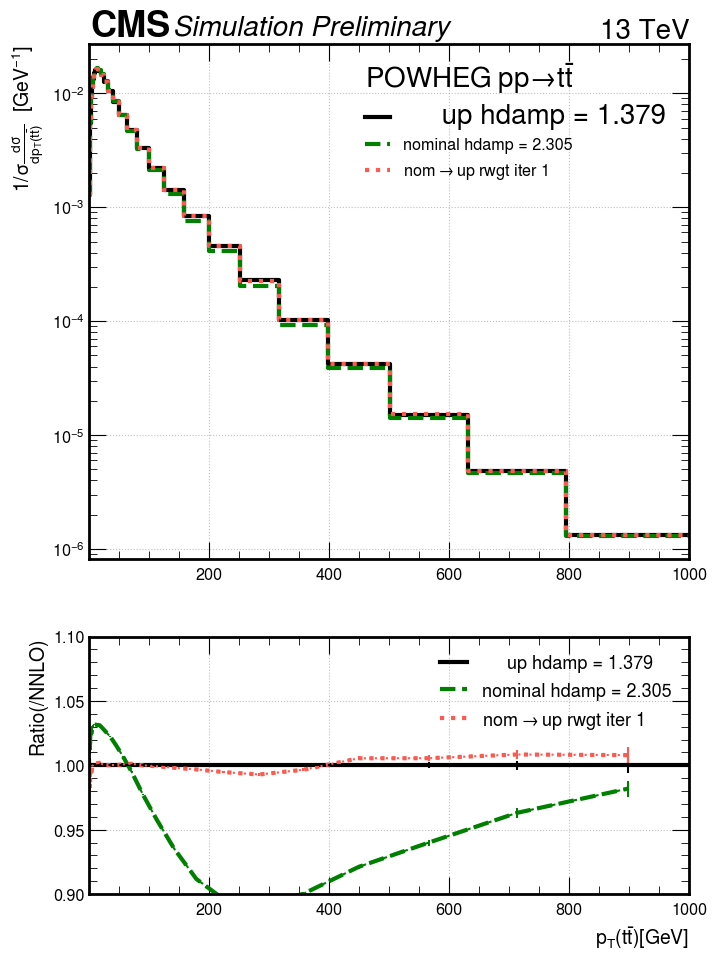


 iteration 1: chi2, mae, 
 7.017259004827066, 4277.278735038782 



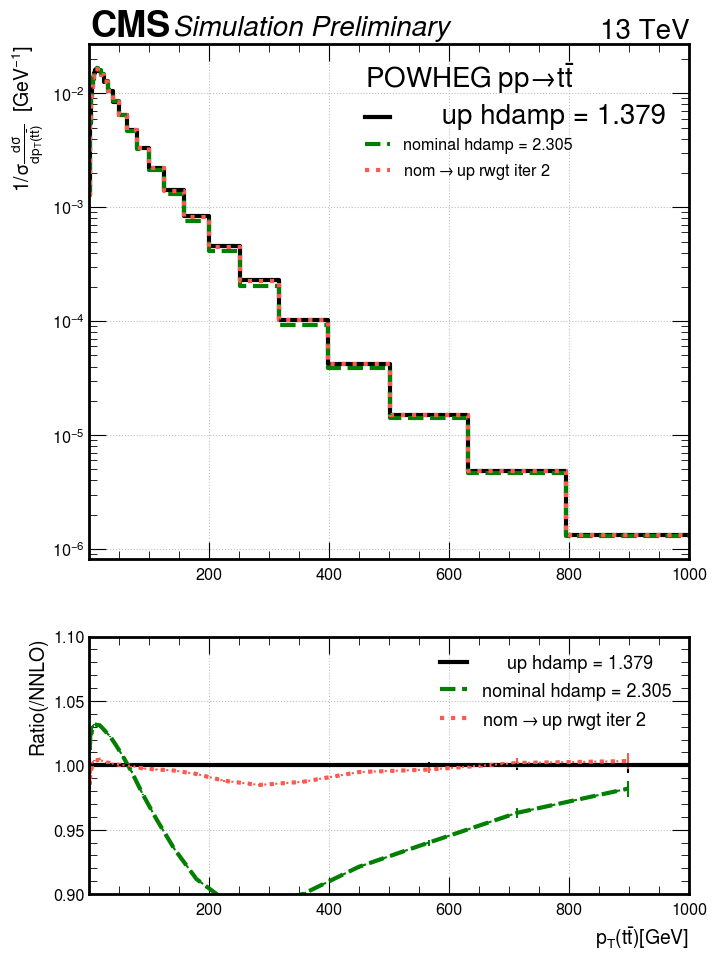


 iteration 2: chi2, mae, 
 29.14667501637737, 10220.768081976708 



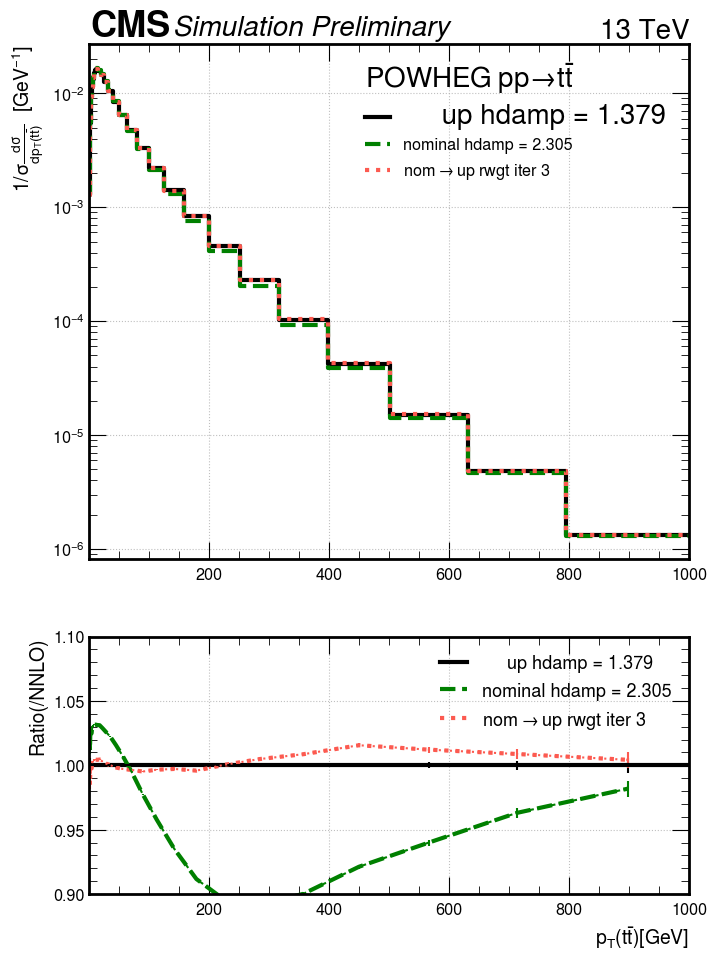


 iteration 3: chi2, mae, 
 21.675247280167845, 10207.267629627242 



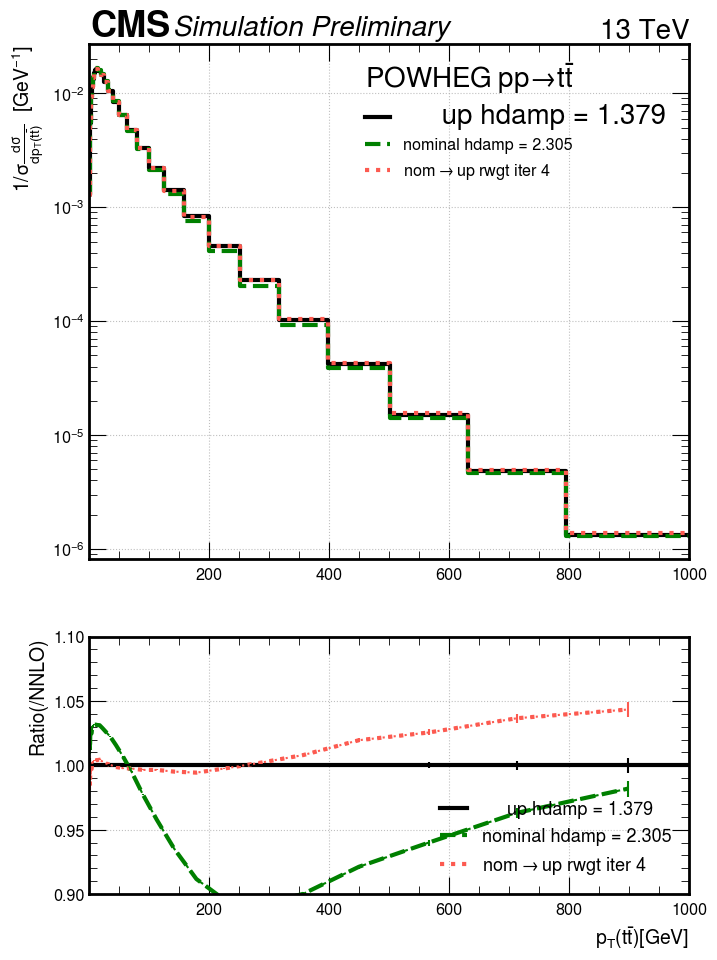


 iteration 4: chi2, mae, 
 24.911710569008623, 10023.977424089735 



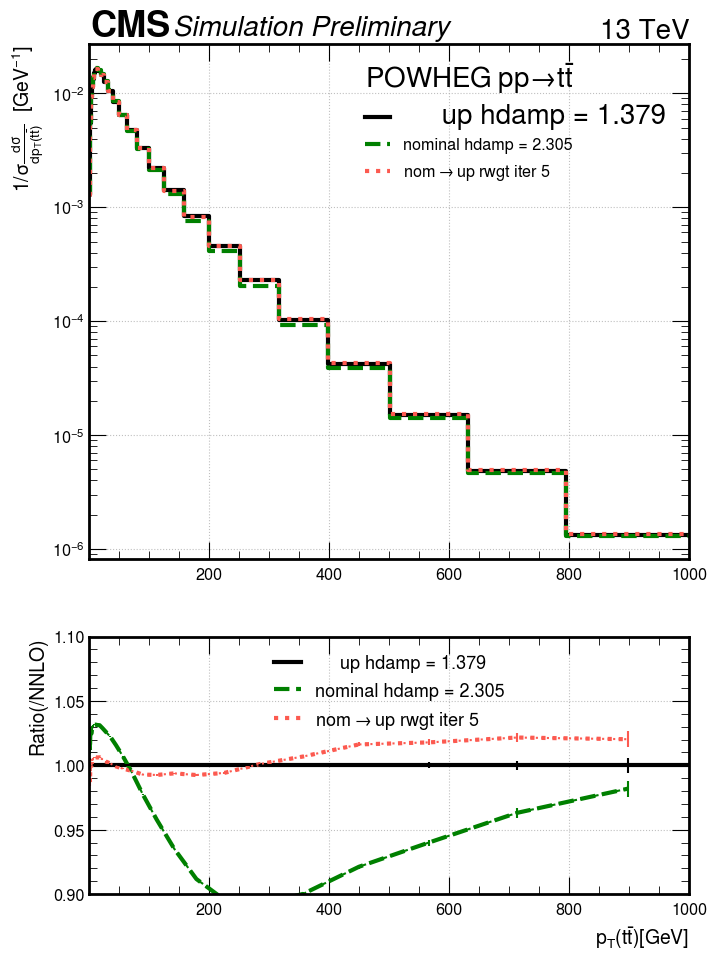


 iteration 5: chi2, mae, 
 45.678744352186435, 15024.882621304738 



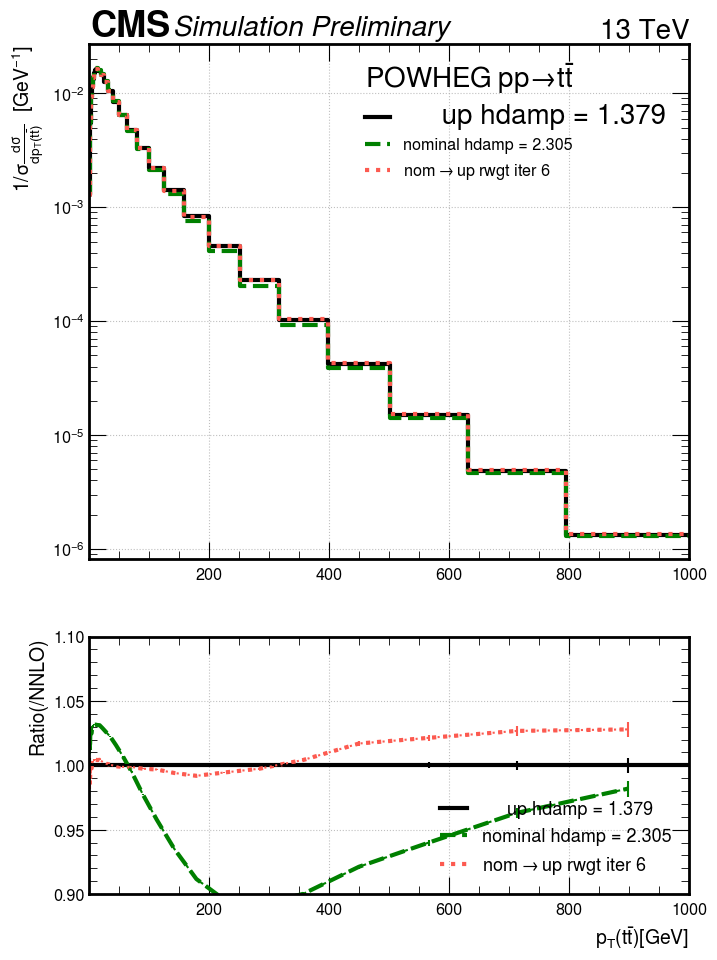


 iteration 6: chi2, mae, 
 23.432953709495646, 9525.419191863715 



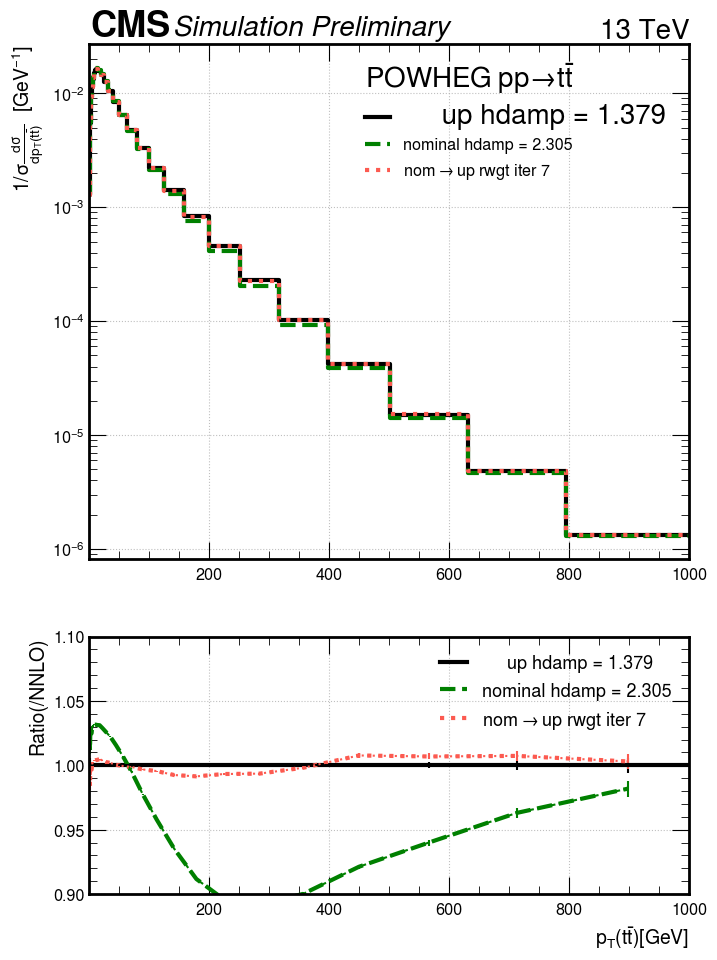


 iteration 7: chi2, mae, 
 26.241815289876367, 10871.220859743122 



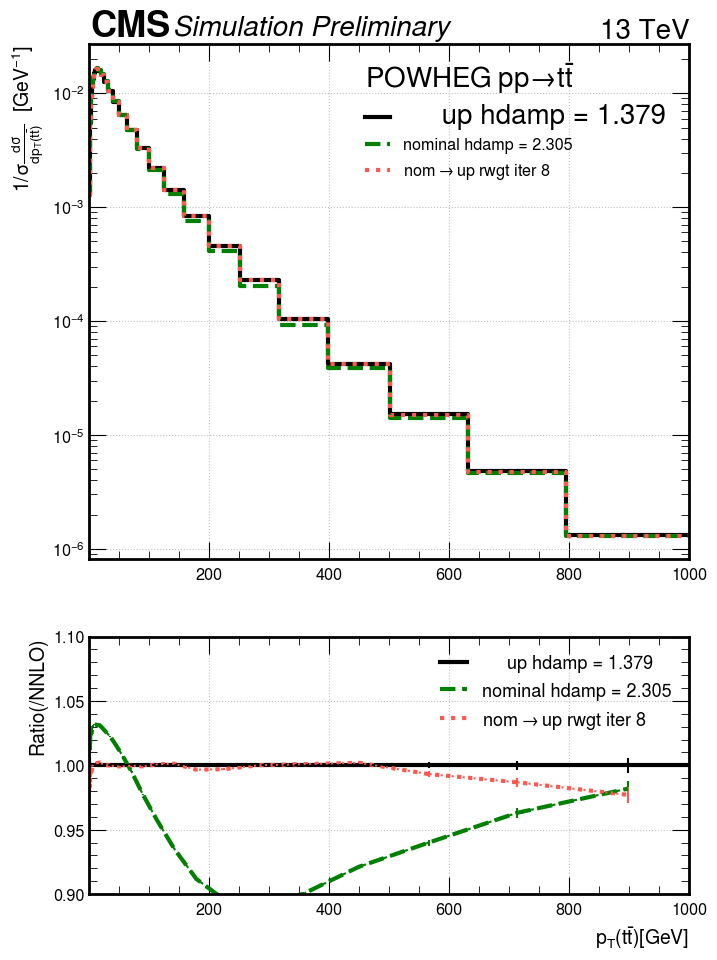


 iteration 8: chi2, mae, 
 5.223623710620069, 3861.441453997456 



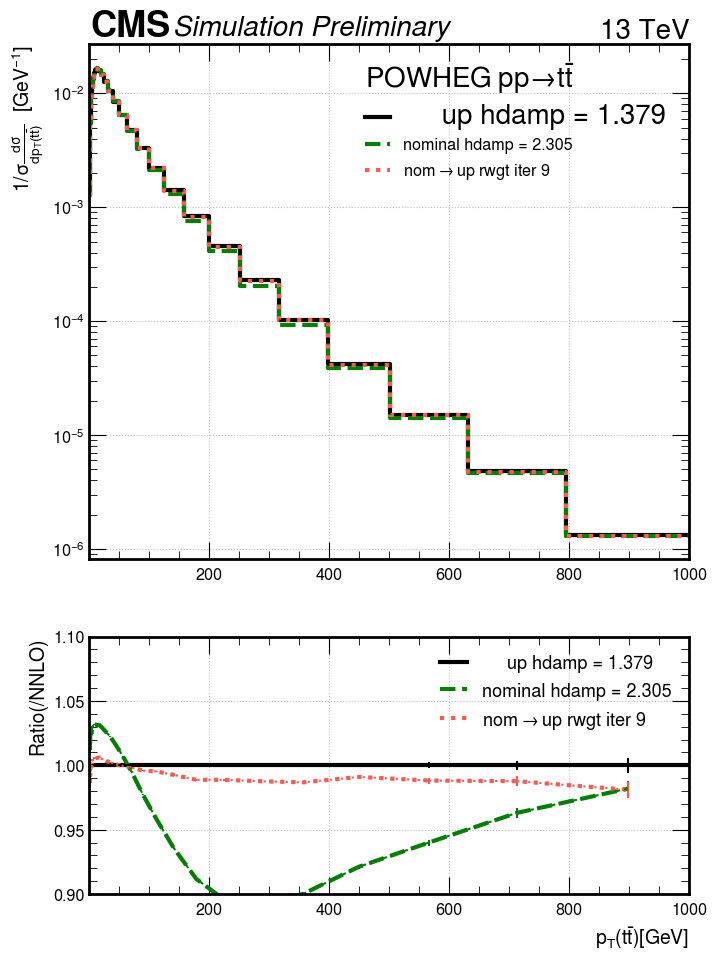


 iteration 9: chi2, mae, 
 46.9711865979071, 14417.782605499726 



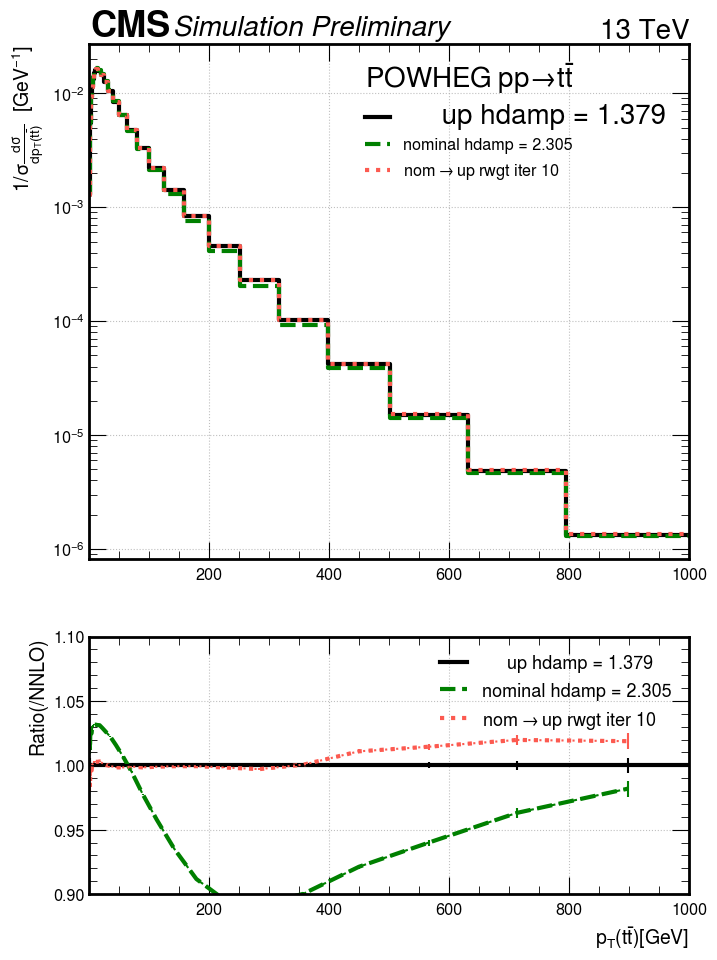


 iteration 10: chi2, mae, 
 8.302595153610994, 5484.921670707943 



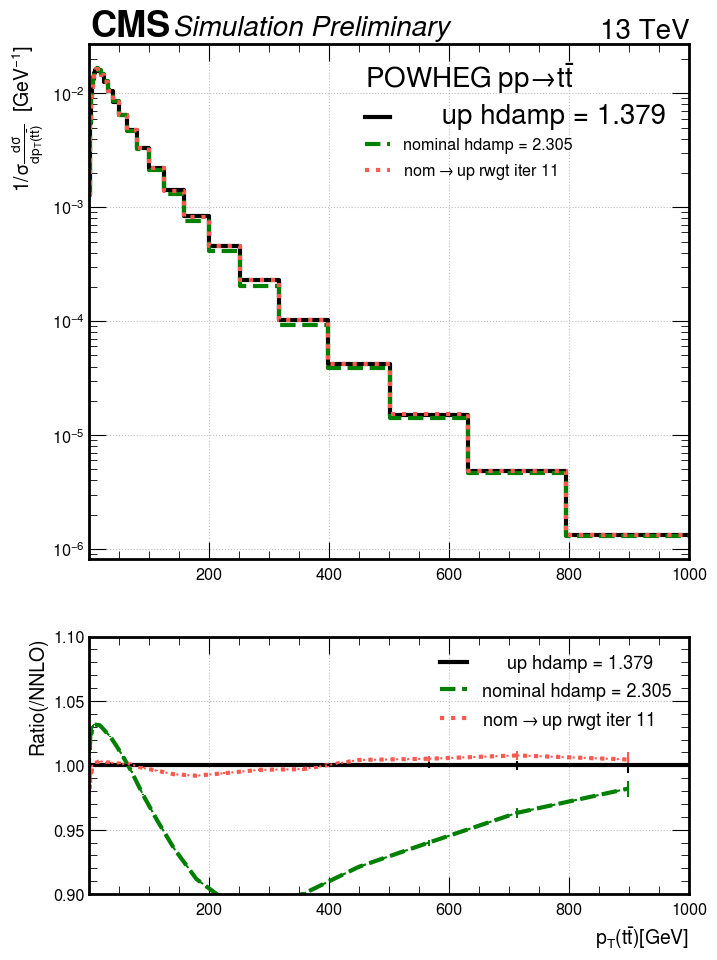


 iteration 11: chi2, mae, 
 18.920301899764226, 9000.336612168292 



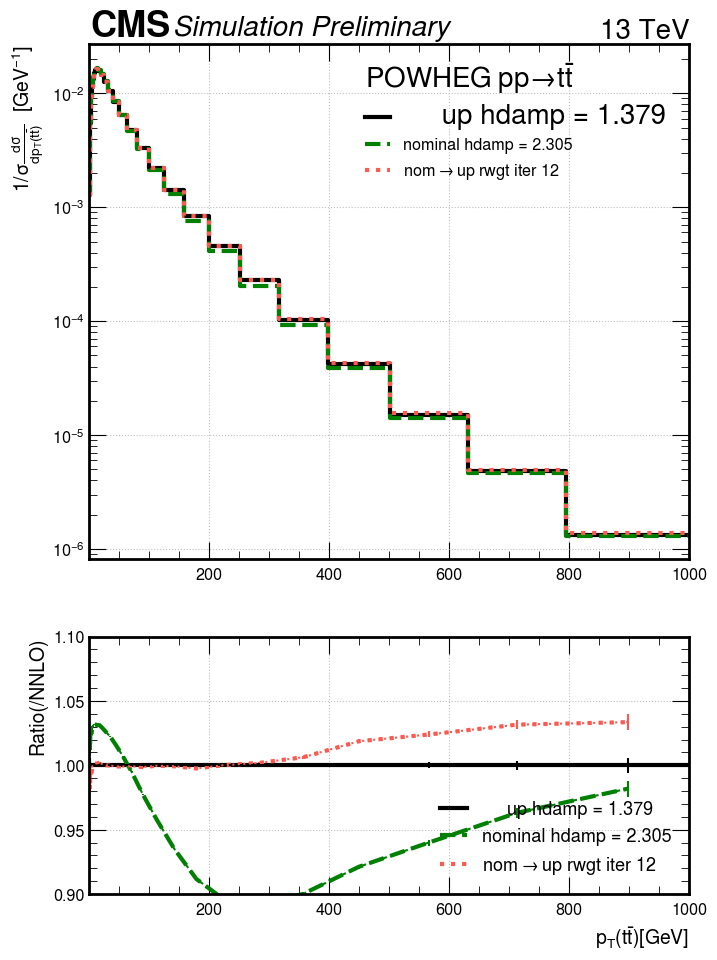


 iteration 12: chi2, mae, 
 10.649742651502367, 4138.8624057810275 



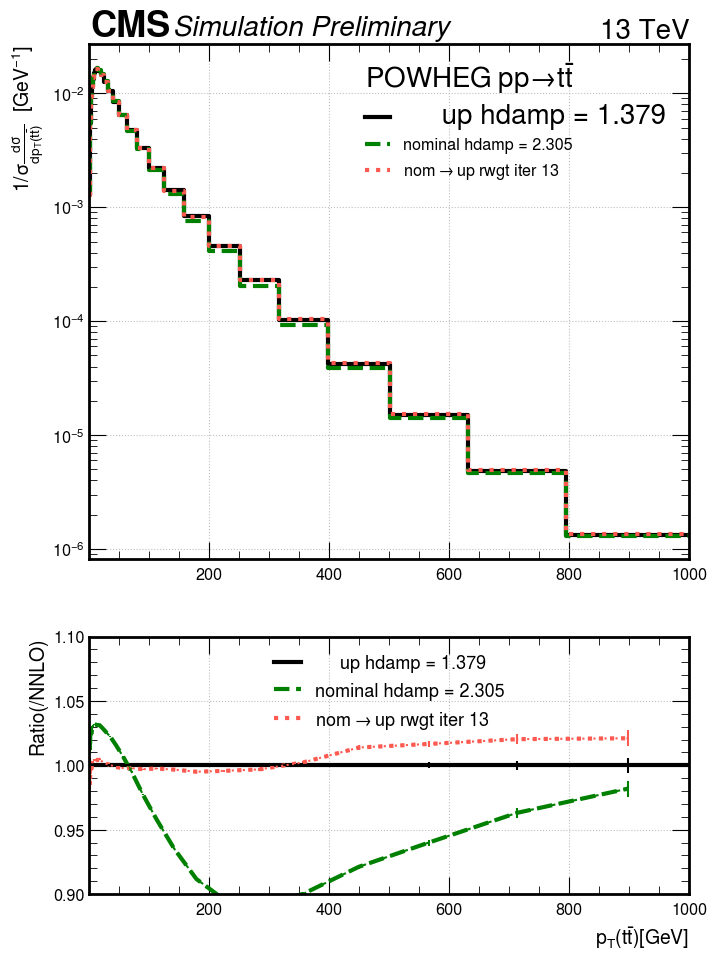


 iteration 13: chi2, mae, 
 17.793433057208176, 9075.431970587579 



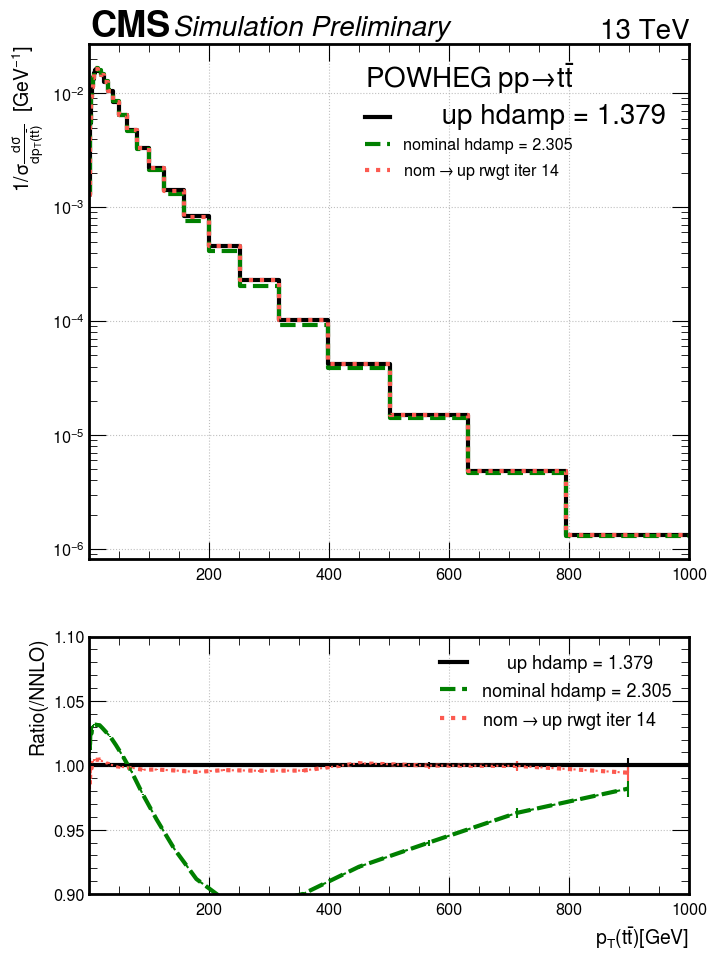


 iteration 14: chi2, mae, 
 16.53435256829174, 9068.955993553378 



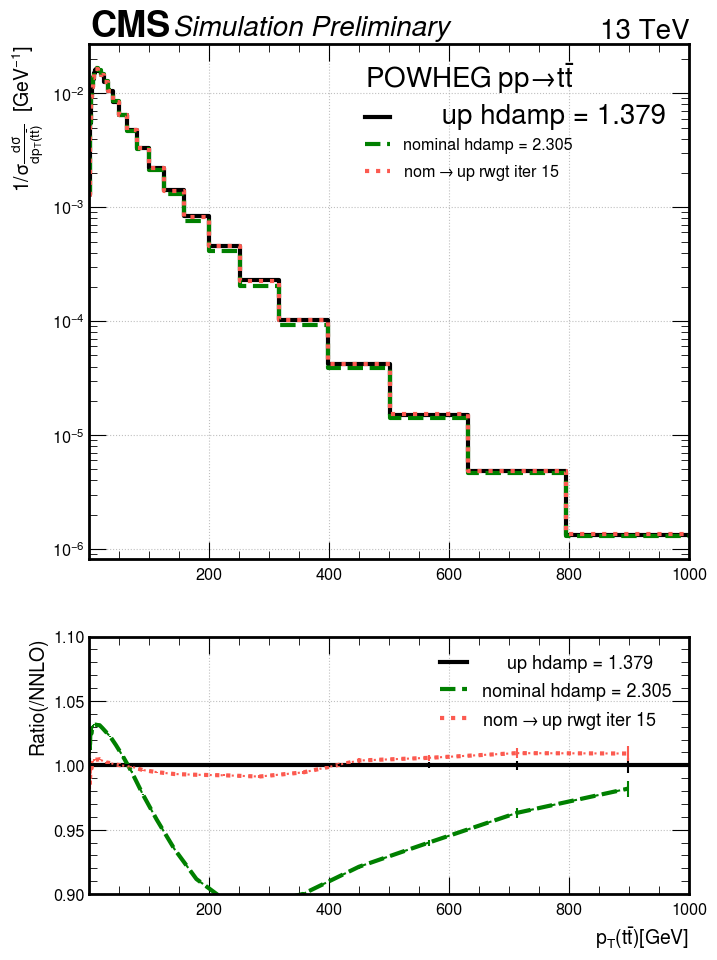


 iteration 15: chi2, mae, 
 26.901930611876082, 11005.528460267236 



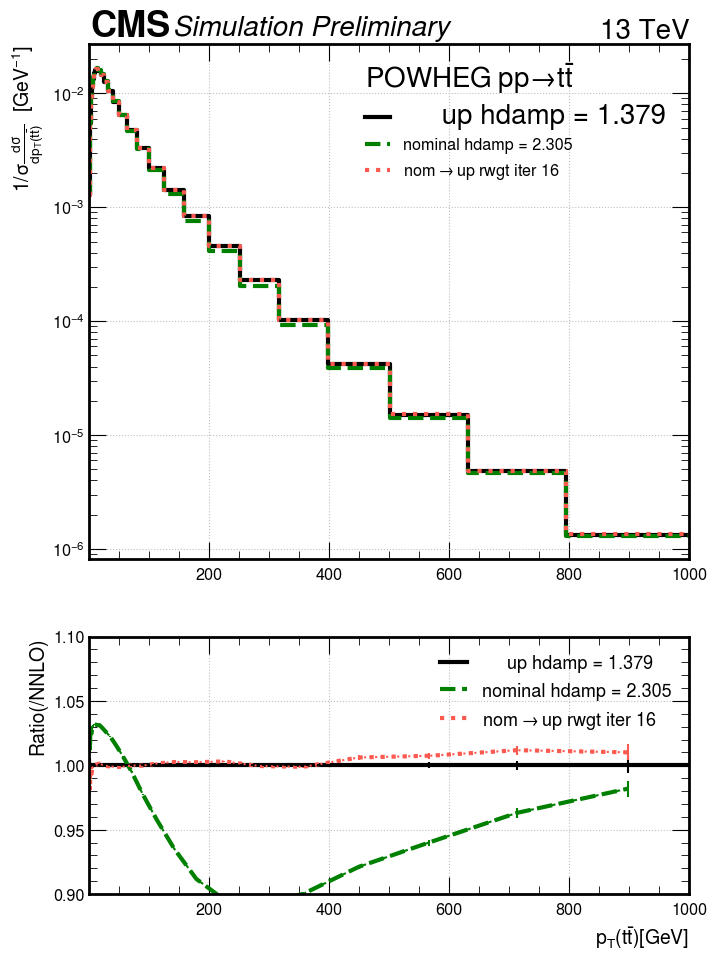


 iteration 16: chi2, mae, 
 5.732376143109721, 3919.3004222299737 



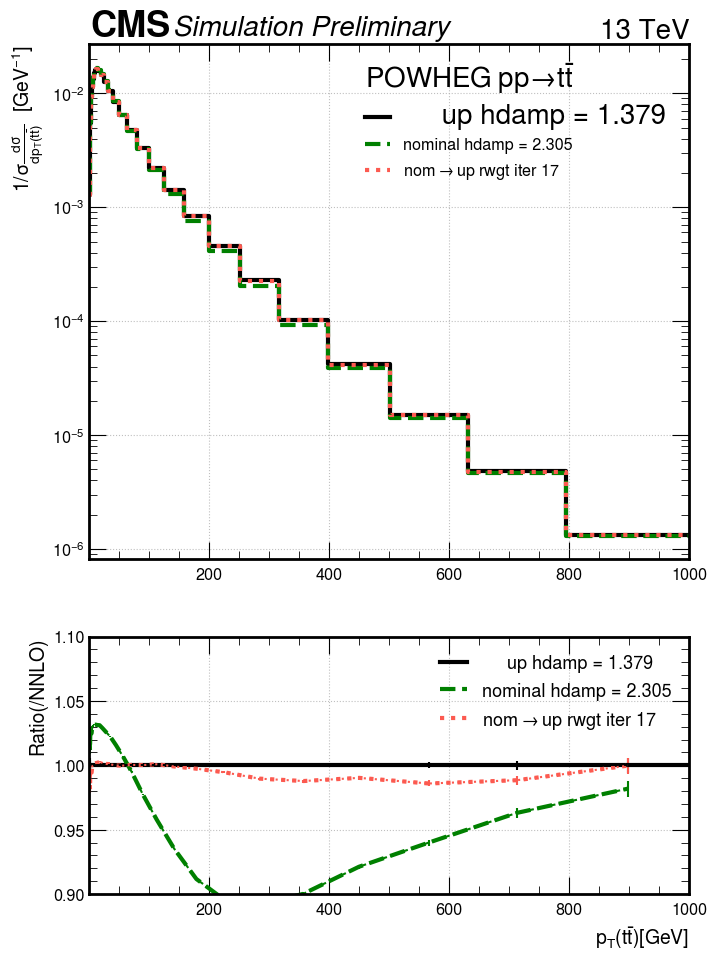


 iteration 17: chi2, mae, 
 12.325056226087149, 5248.144372797401 



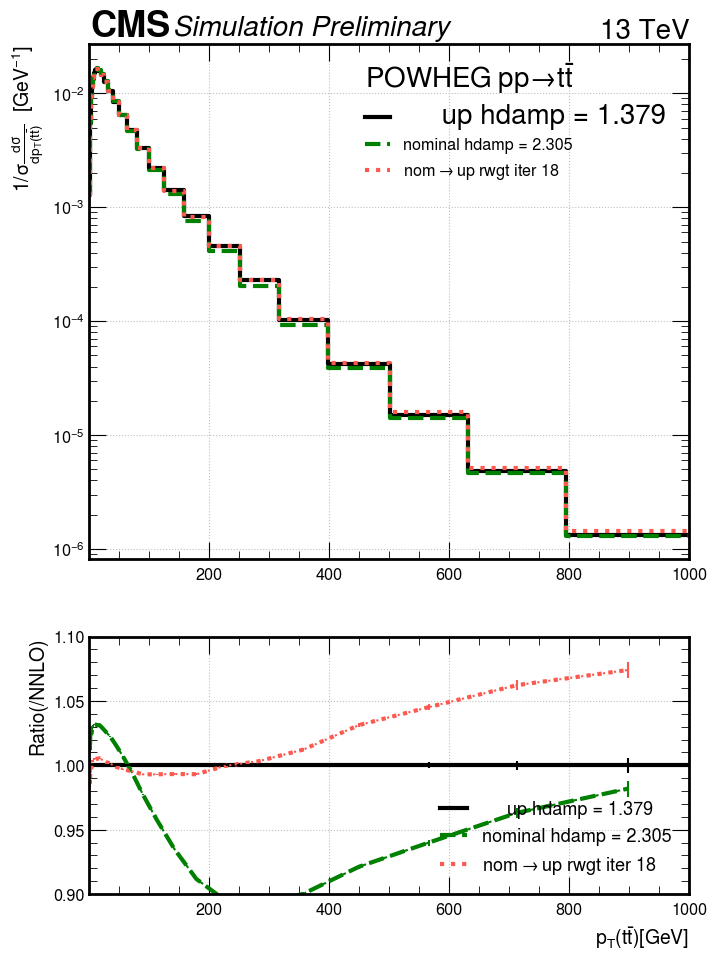


 iteration 18: chi2, mae, 
 56.71965197494193, 14624.65640378974 



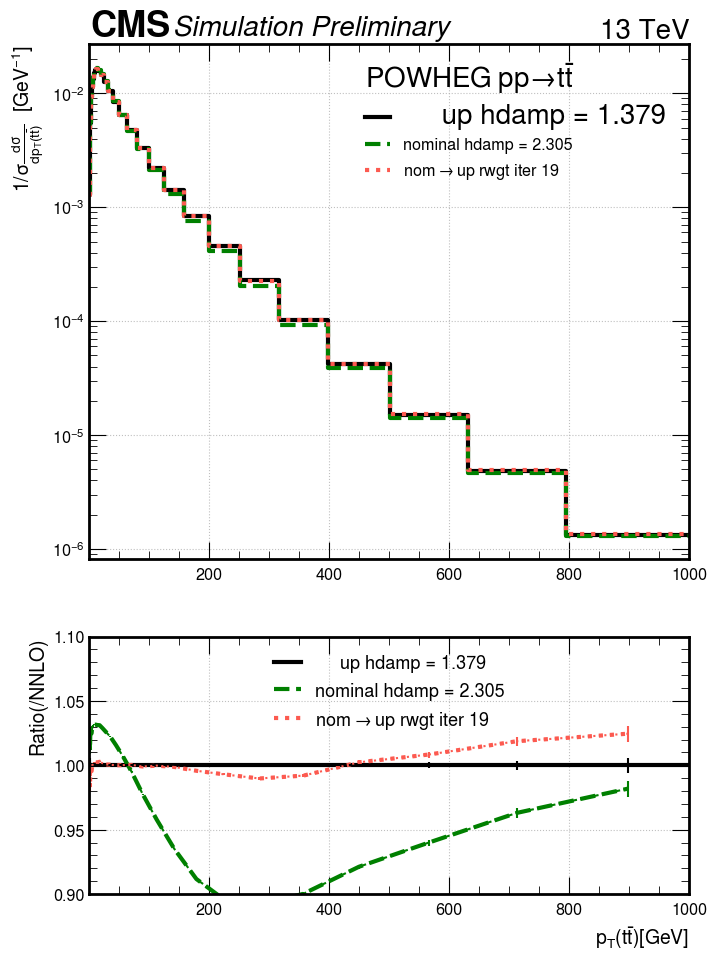


 iteration 19: chi2, mae, 
 11.555453869955278, 5269.508349257531 



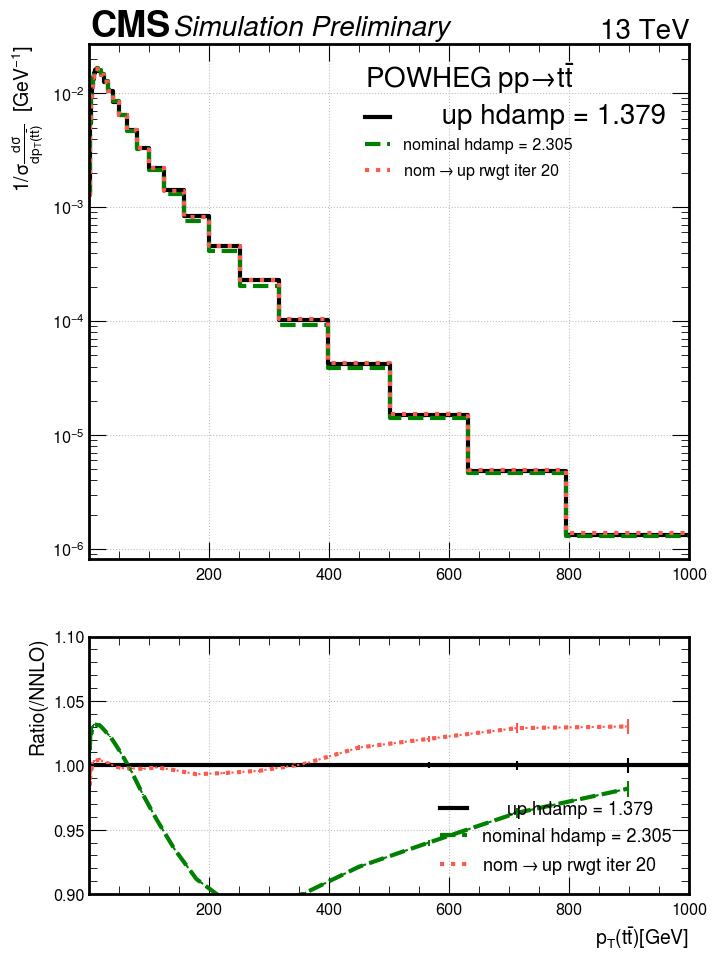


 iteration 20: chi2, mae, 
 20.957986618730857, 9644.987699036868 



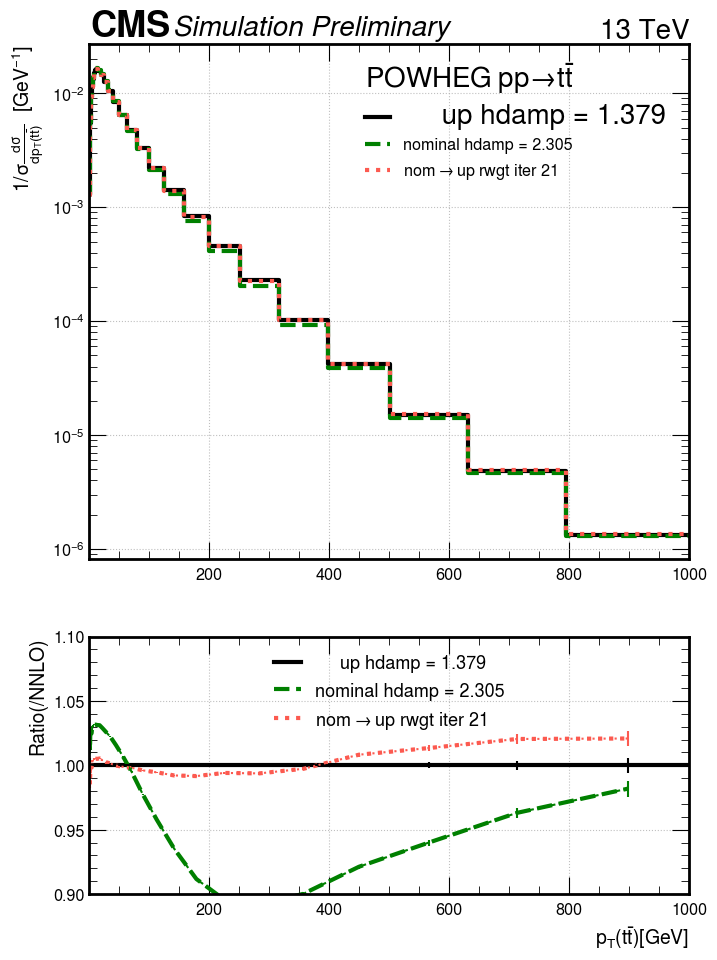


 iteration 21: chi2, mae, 
 31.568182623552264, 12037.841758015782 



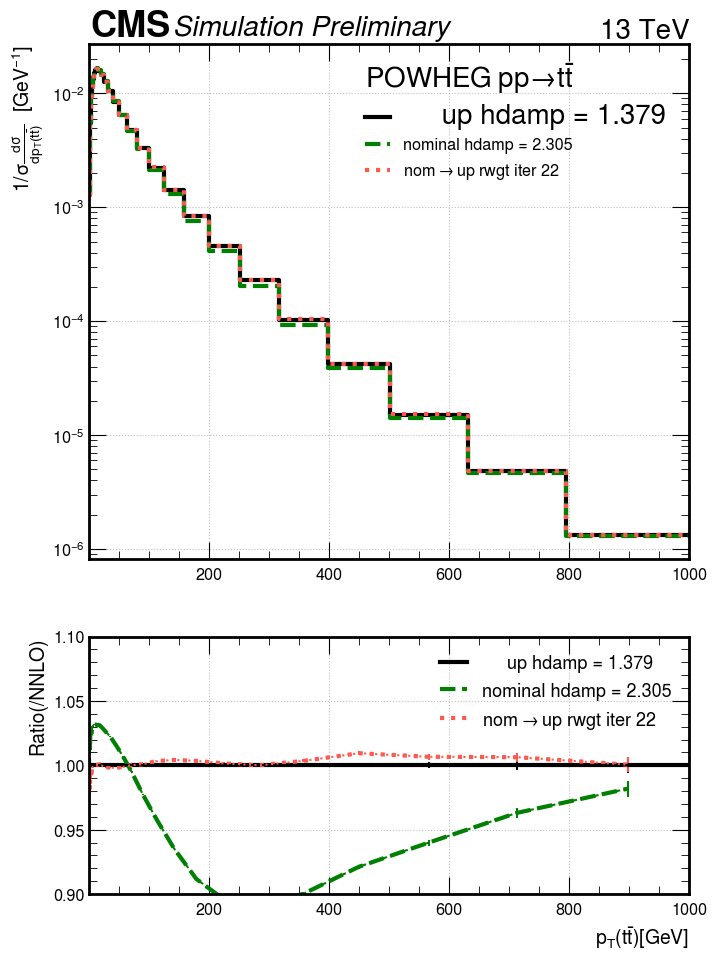


 iteration 22: chi2, mae, 
 8.46599954988196, 5268.384639687535 



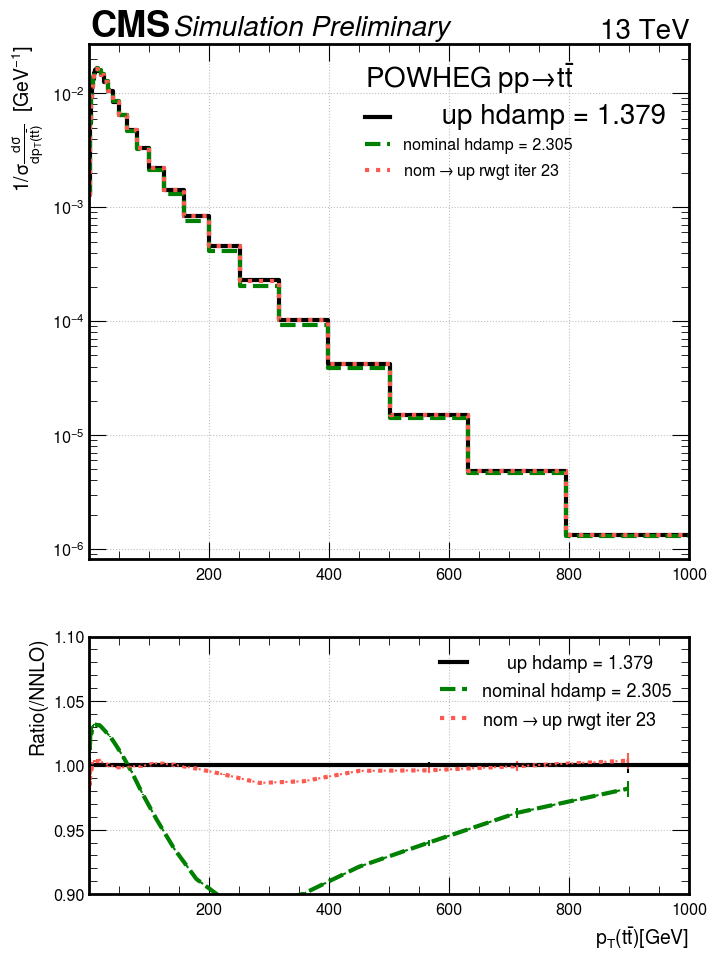


 iteration 23: chi2, mae, 
 16.0580913678697, 6953.85949356274 



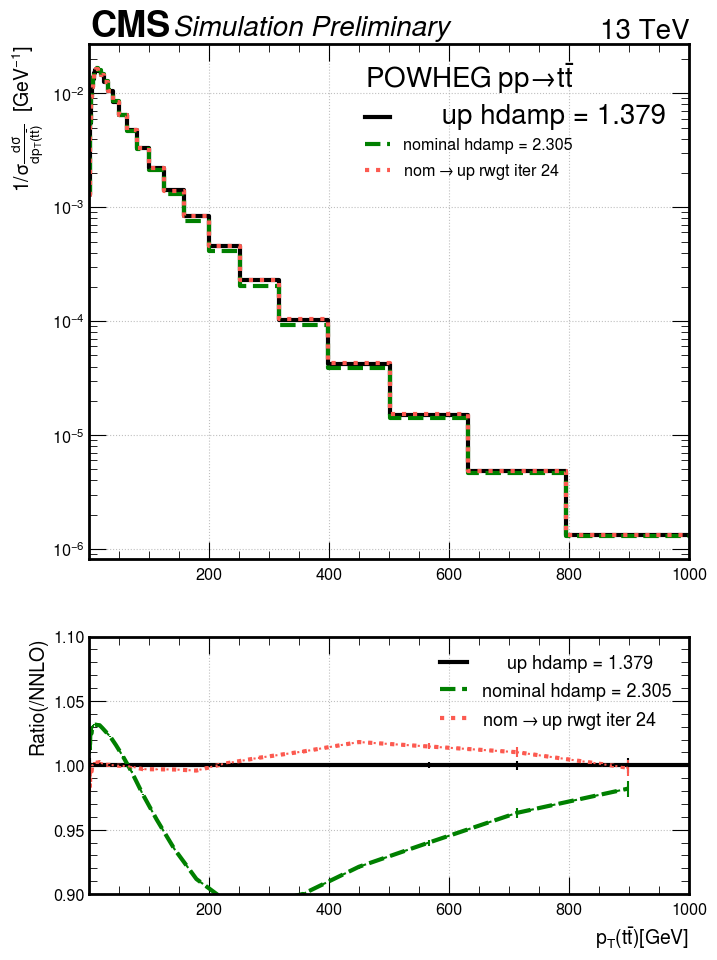


 iteration 24: chi2, mae, 
 13.153231727196513, 6223.264496768717 



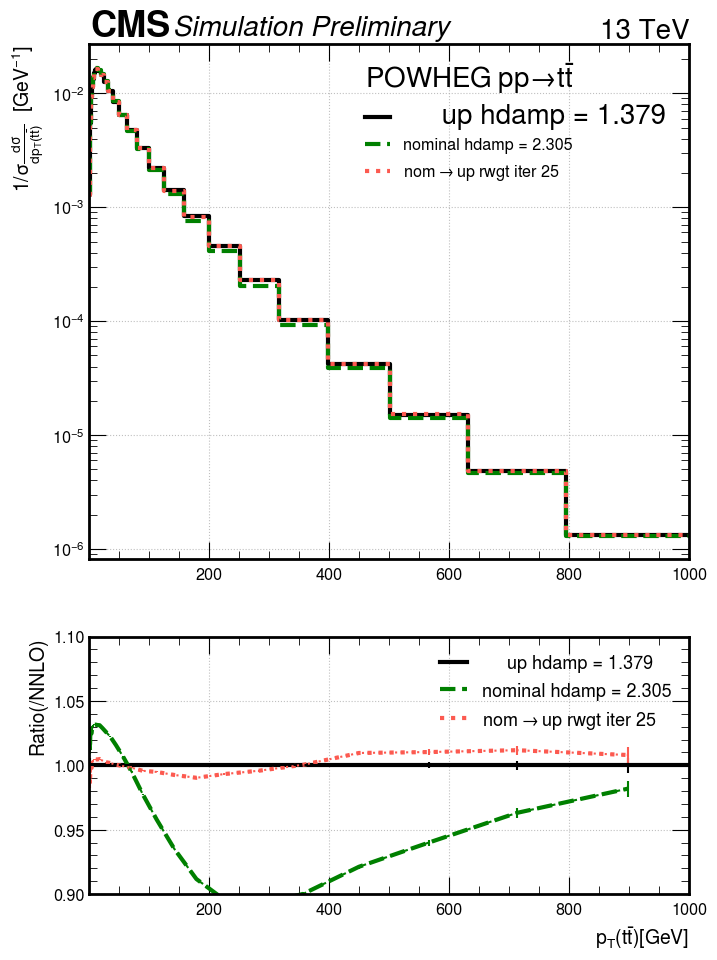


 iteration 25: chi2, mae, 
 29.845491803283878, 11633.935233106587 



In [156]:
# tt-pair pt
chi2_all = []
mae_all  = []

for i, wgts in enumerate(wgts_list):
    # setup args for plotting
    args = [(X0_plot[:,0], X0_plot_wgt, '     up hdamp = 1.379 '),
            (X1_plot[:,0], X1_plot_wgt, 'nominal hdamp = 2.305'),
            (X1_plot[:,0], wgts,      fr'nom$\rightarrow$up rwgt iter {i + 1}')]
    
    log_bins = np.logspace(np.log10(1), np.log10(1000), 31)
    DCTR.plot_ratio_cms(args, bins = log_bins, y_scale='log', ratio_ylim=[0.9, 1.1], save_prefix = f'iter_{i+1:02d}',
                        part_label=r't\bar{t}', arg_label=r'p_{T}', unit=r' [GeV]', inv_unit=r' [GeV$^{-1}$]')
    # stats
    mae_list, chi2_list, p_list = DCTR.plot_ratio(args, bins = log_bins, stats_only = True, verbose=False)
    
    # last element is the one we're interested in, the others are the baseline nom and up
    print(f'\n iteration {i + 1}: chi2, mae, \n {chi2_list[-1]}, {mae_list[-1]} \n')

    chi2_all.append(chi2_list[-1])
    mae_all.append(mae_list[-1])



In [157]:
chi2_all = np.array(chi2_all)
mae_all = np.array(mae_all)

print(f'{chi2_all = }\n')

print(f'{mae_all = }\n')

min_chi2  = np.min(chi2_all)
max_chi2  = np.max(chi2_all)
mean_chi2 = np.mean(chi2_all)
std_chi2  = np.std(chi2_all)

min_mae   = np.min(mae_all)
max_mae   = np.max(mae_all)
mean_mae  = np.mean(mae_all)
std_mae   = np.std(mae_all)

print(f'chi2: min, max, mean, std\n\
{min_chi2:5f}, {max_chi2:5f}, {mean_chi2:5f}, {std_chi2:5f}\n')

print(f'mea : min, max, mean, std\n\
{min_mae:5f}, {max_mae:5f}, {mean_mae:5f}, {std_mae:5f}\n')

# pt(tt) log_bins = np.logspace(np.log10(1), np.log10(1000), 31)

chi2_all = array([ 7.017, 29.147, 21.675, 24.912, 45.679, 23.433, 26.242,  5.224,
       46.971,  8.303, 18.92 , 10.65 , 17.793, 16.534, 26.902,  5.732,
       12.325, 56.72 , 11.555, 20.958, 31.568,  8.466, 16.058, 13.153,
       29.845])

mae_all = array([ 4277.279, 10220.768, 10207.268, 10023.977, 15024.883,  9525.419,
       10871.221,  3861.441, 14417.783,  5484.922,  9000.337,  4138.862,
        9075.432,  9068.956, 11005.528,  3919.3  ,  5248.144, 14624.656,
        5269.508,  9644.988, 12037.842,  5268.385,  6953.859,  6223.264,
       11633.935])

chi2: min, max, mean, std
5.223624, 56.719652, 21.431324, 13.088977

mea : min, max, mean, std
3861.441454, 15024.882621, 8681.118343, 3390.919903



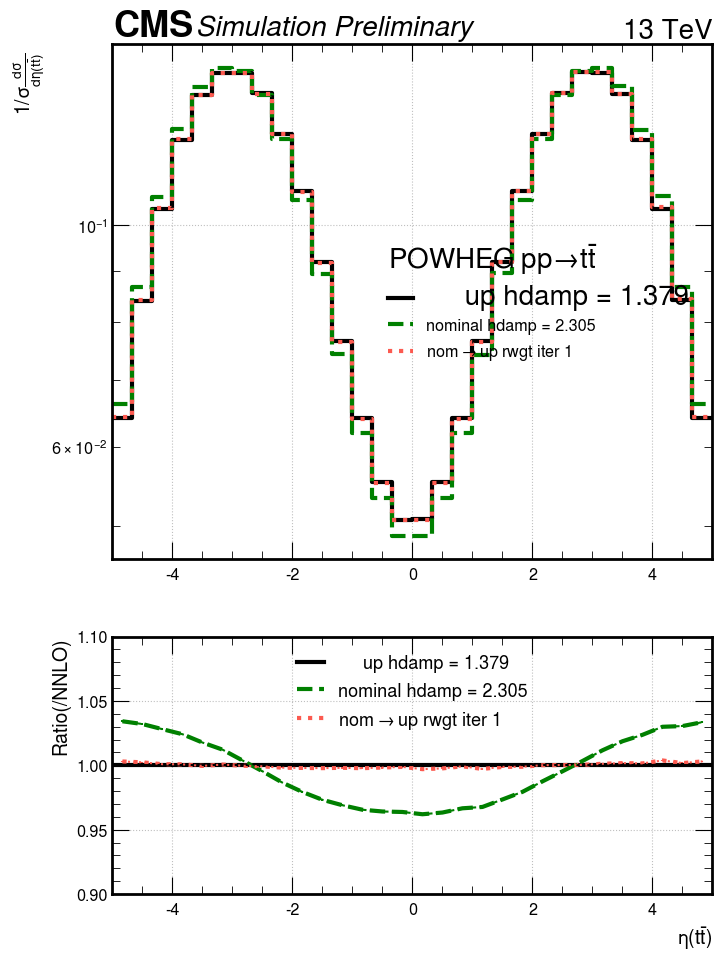

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 1: chi2, mae, 
 3.406598550503684, 3233.077293109432 



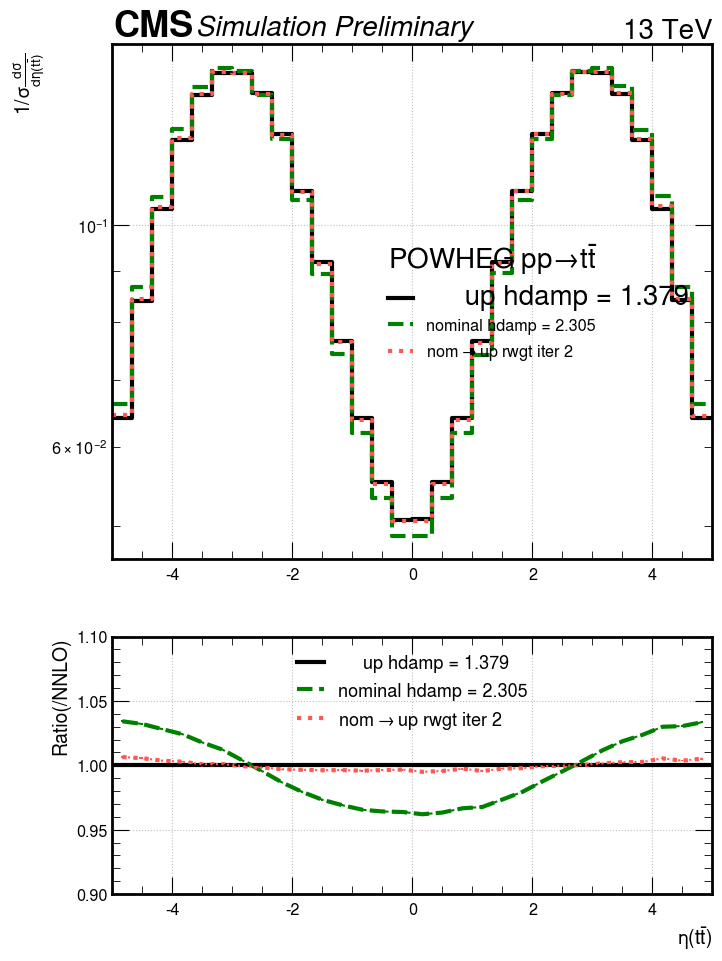

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 2: chi2, mae, 
 6.5604215230799126, 4658.878403334172 



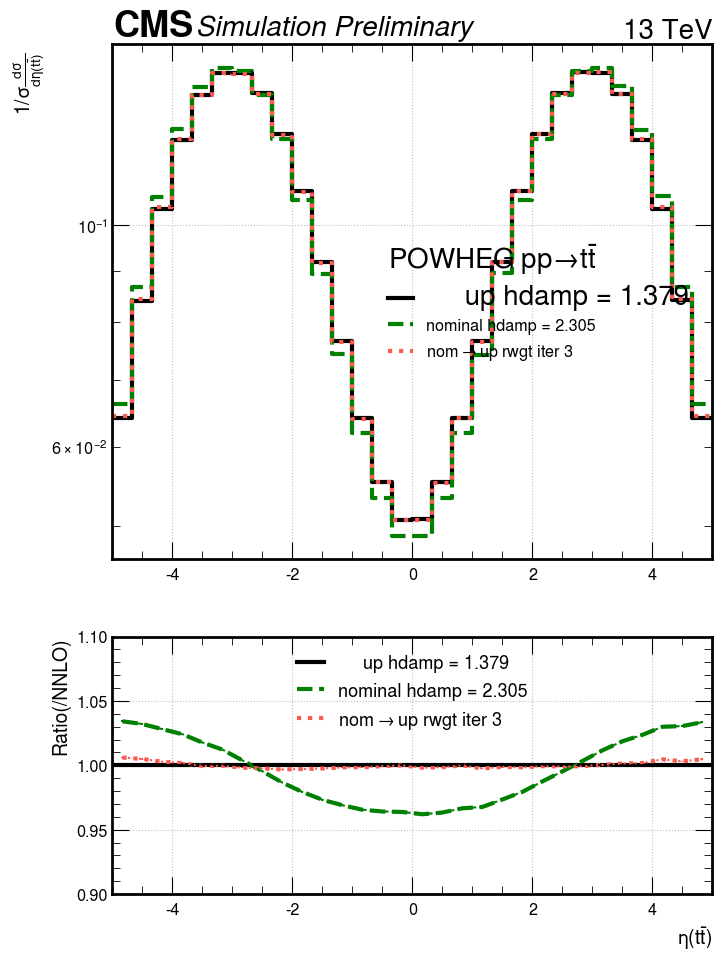

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 3: chi2, mae, 
 4.374662927804196, 3521.9164147403403 



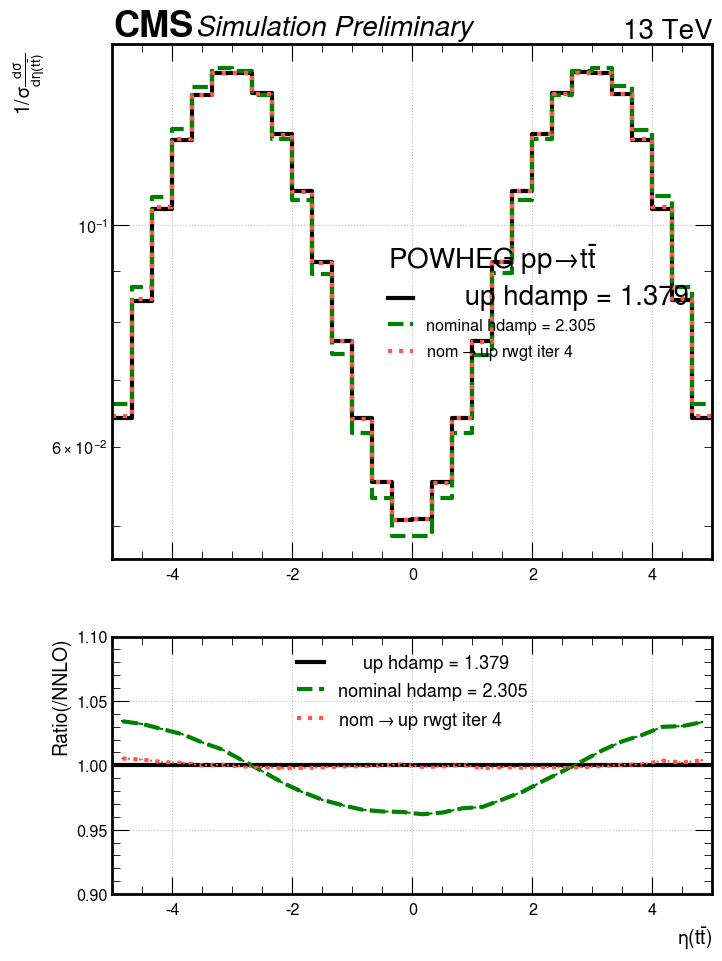

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 4: chi2, mae, 
 3.500320236458427, 2579.3468342688557 



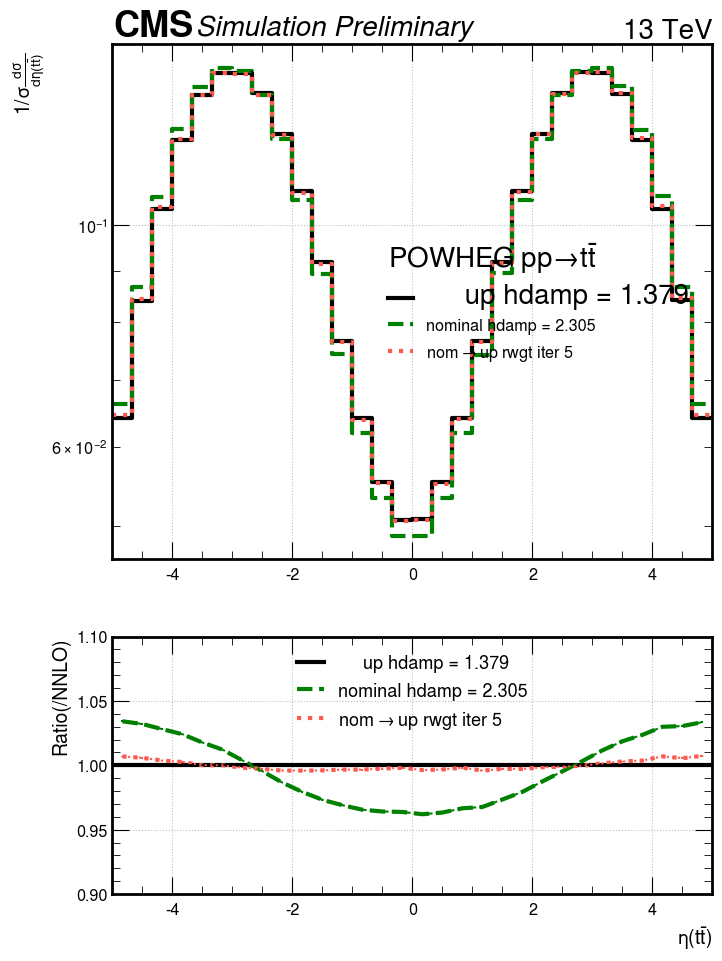

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 5: chi2, mae, 
 11.236521961718942, 6284.040287354117 



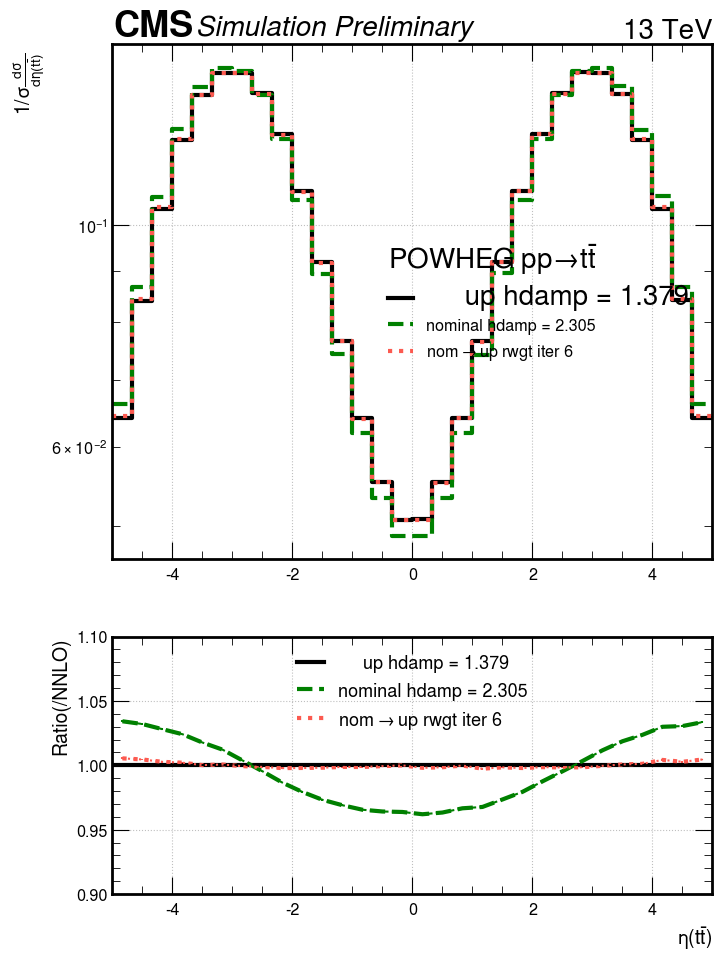

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 6: chi2, mae, 
 4.23937122393881, 2905.57207457493 



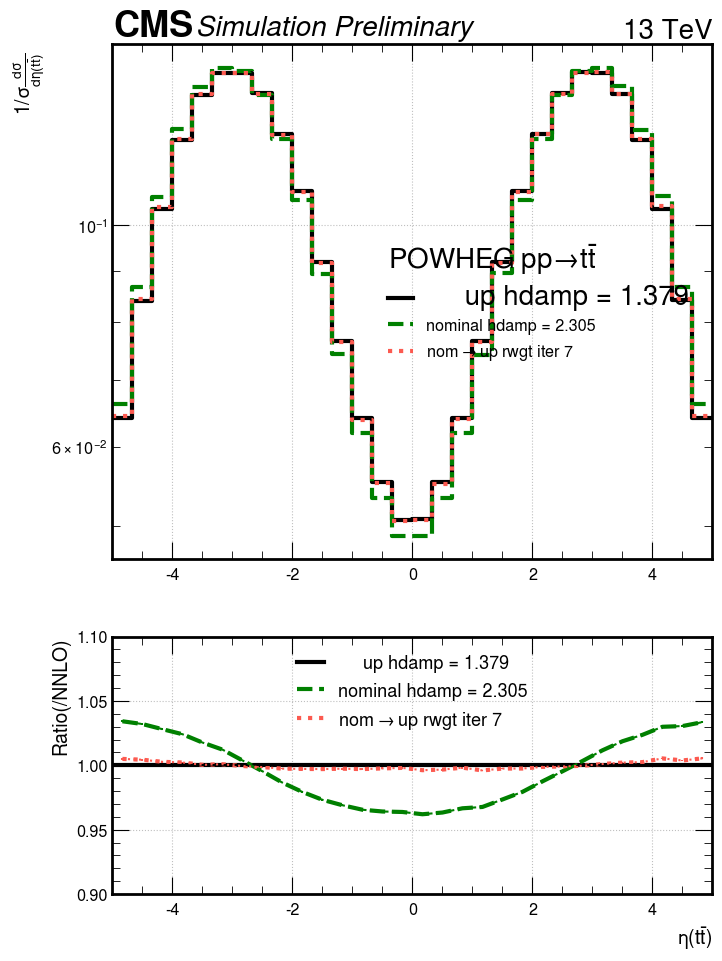

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 7: chi2, mae, 
 6.476080801308928, 4551.873493589105 



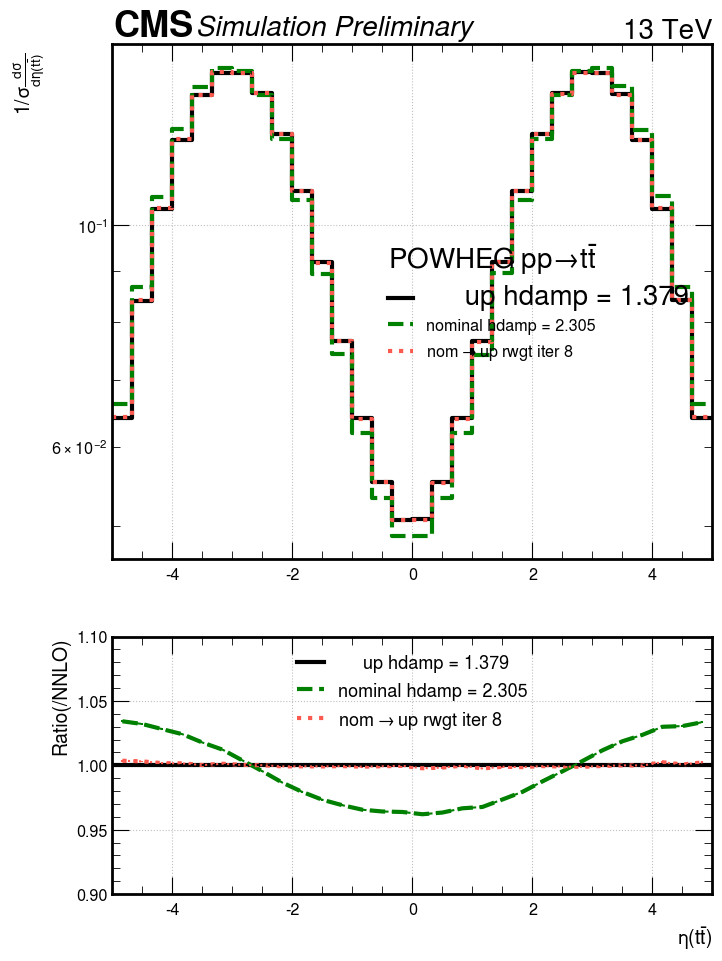

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 8: chi2, mae, 
 1.9118940101461428, 1873.7912952703991 



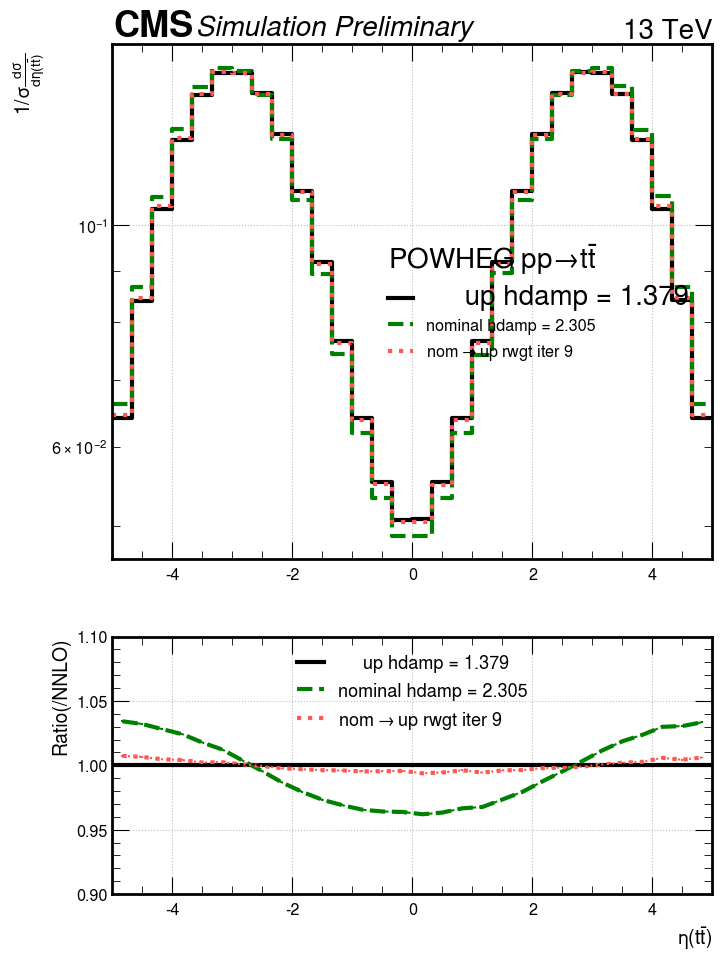

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 9: chi2, mae, 
 8.682835416364416, 4840.359860378926 



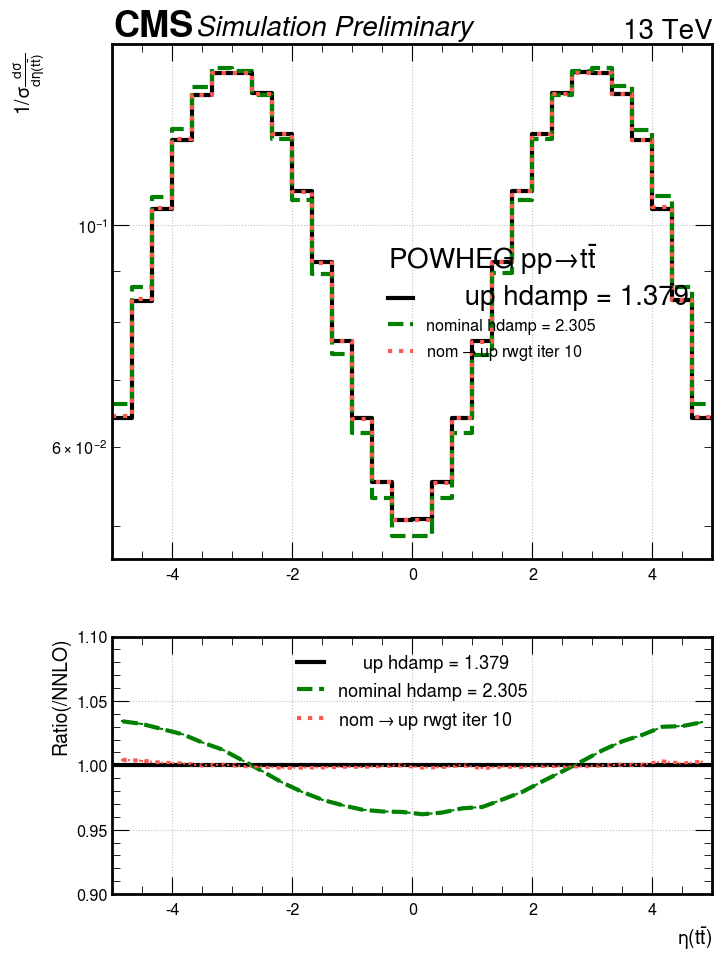

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 10: chi2, mae, 
 2.3019065461383343, 1776.4703092368372 



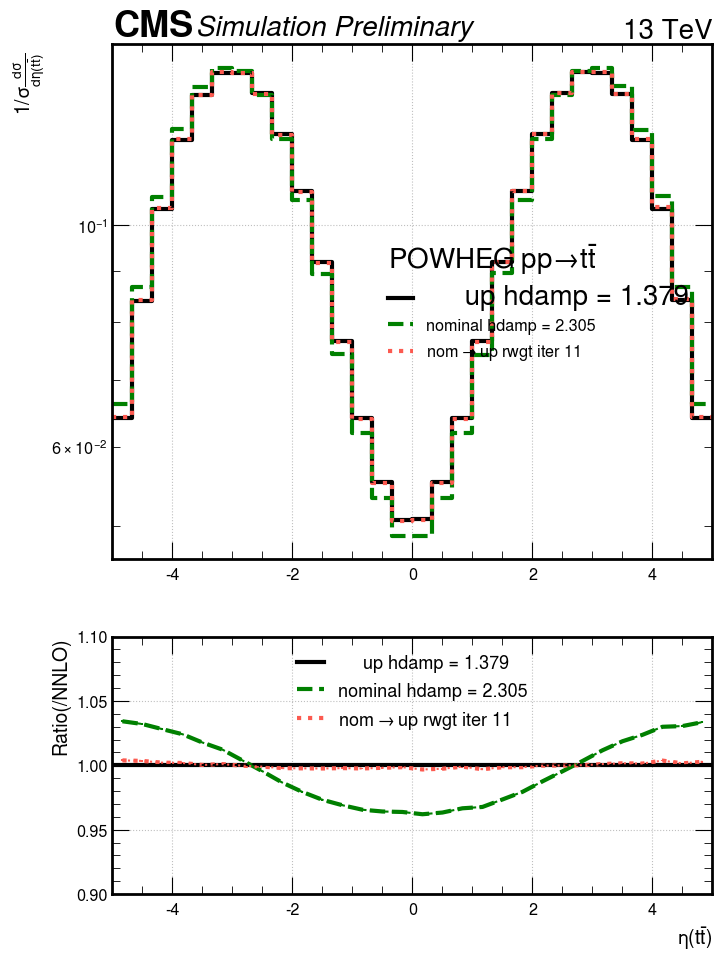

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 11: chi2, mae, 
 3.328671323272016, 2683.62605592279 



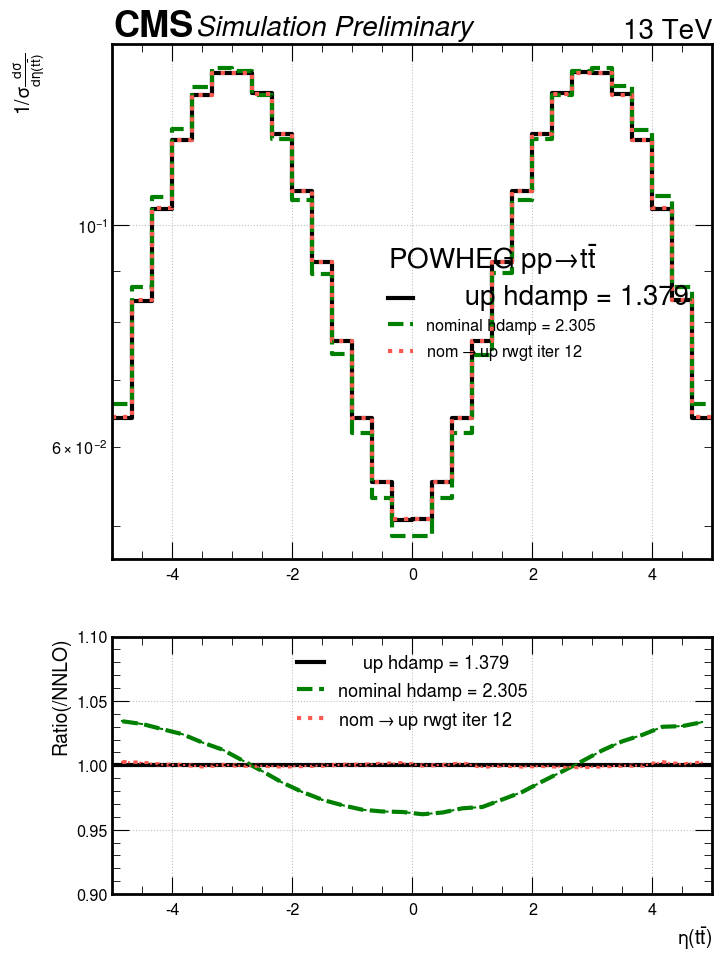

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 12: chi2, mae, 
 2.0099132481637834, 1808.6925438449002 



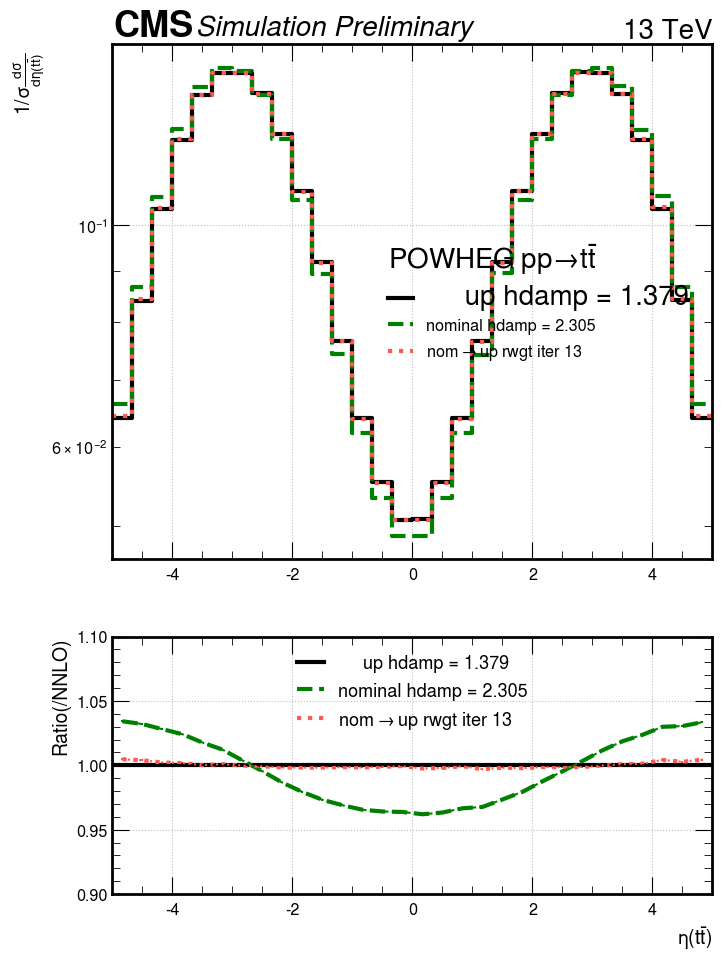

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 13: chi2, mae, 
 4.1383049973347035, 3023.9511488145595 



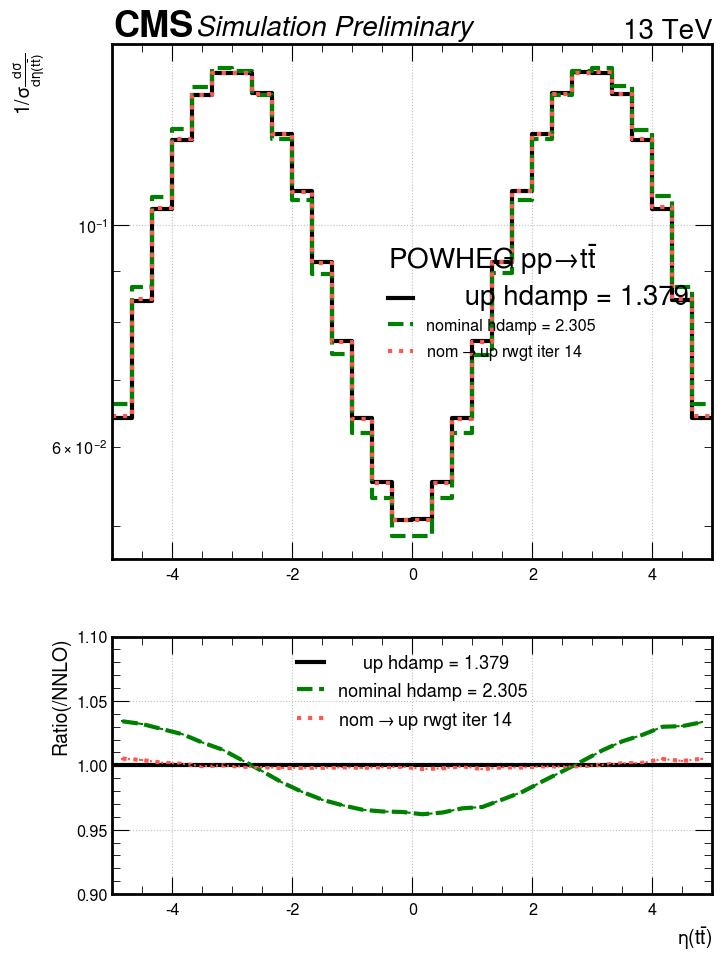

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 14: chi2, mae, 
 5.084127698215637, 3892.5319101902783 



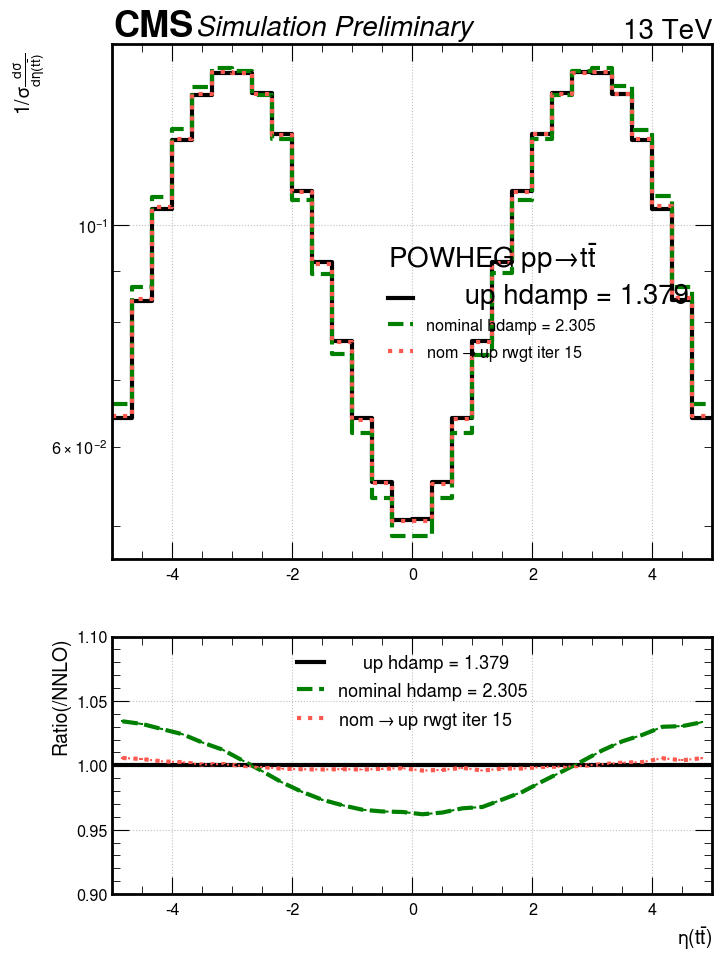

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 15: chi2, mae, 
 6.760667476002833, 4593.31918178844 



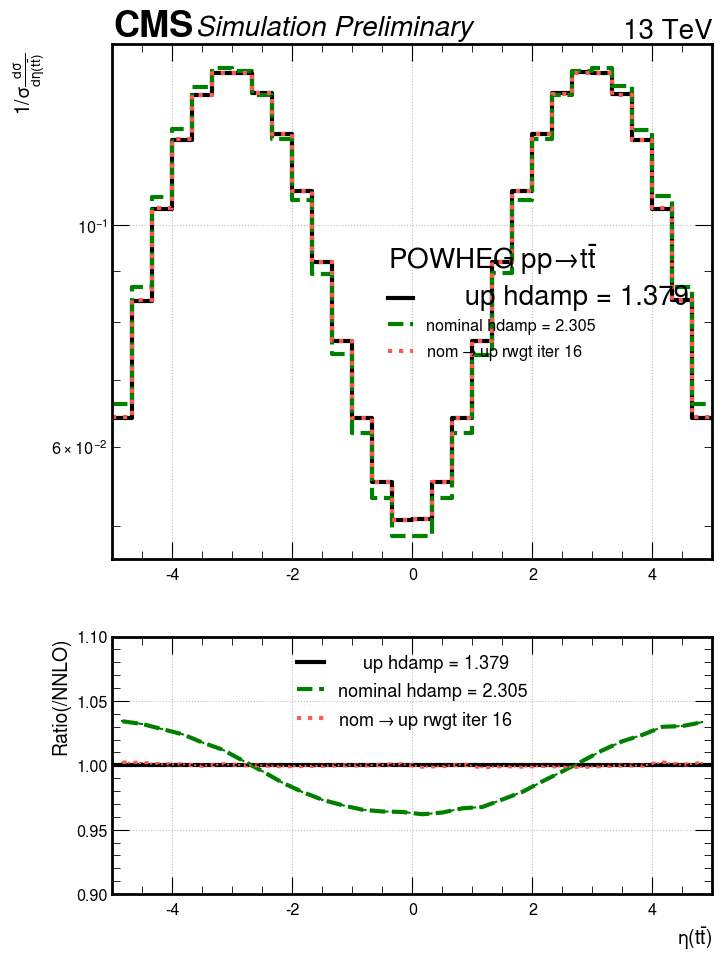

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 16: chi2, mae, 
 2.0181221947075407, 1565.5743457176764 



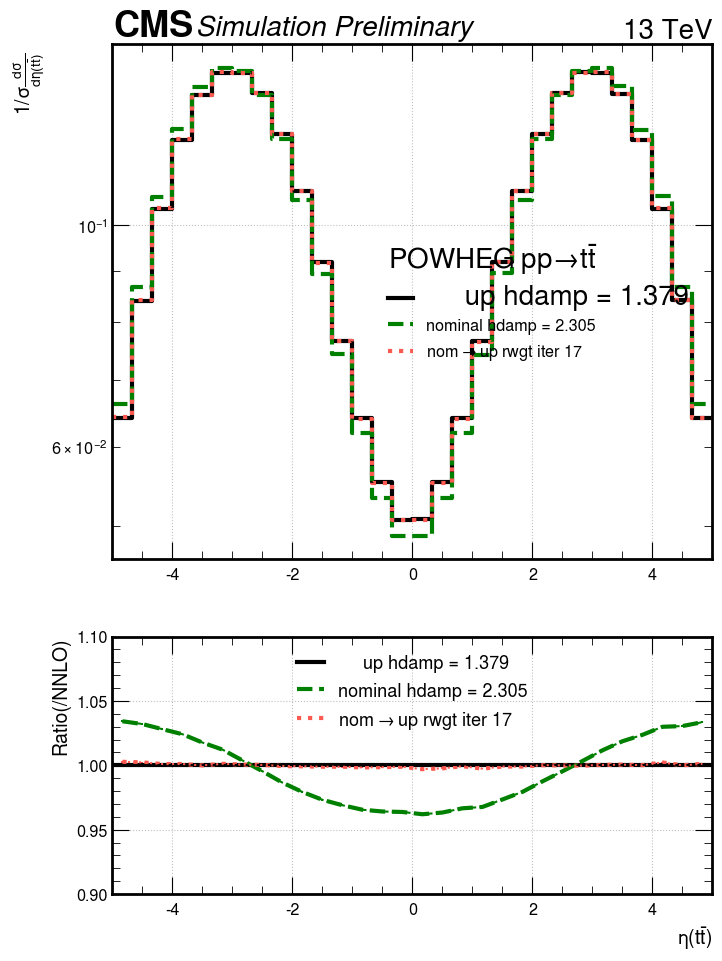

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 17: chi2, mae, 
 2.2867793755490062, 1191.5146928414 



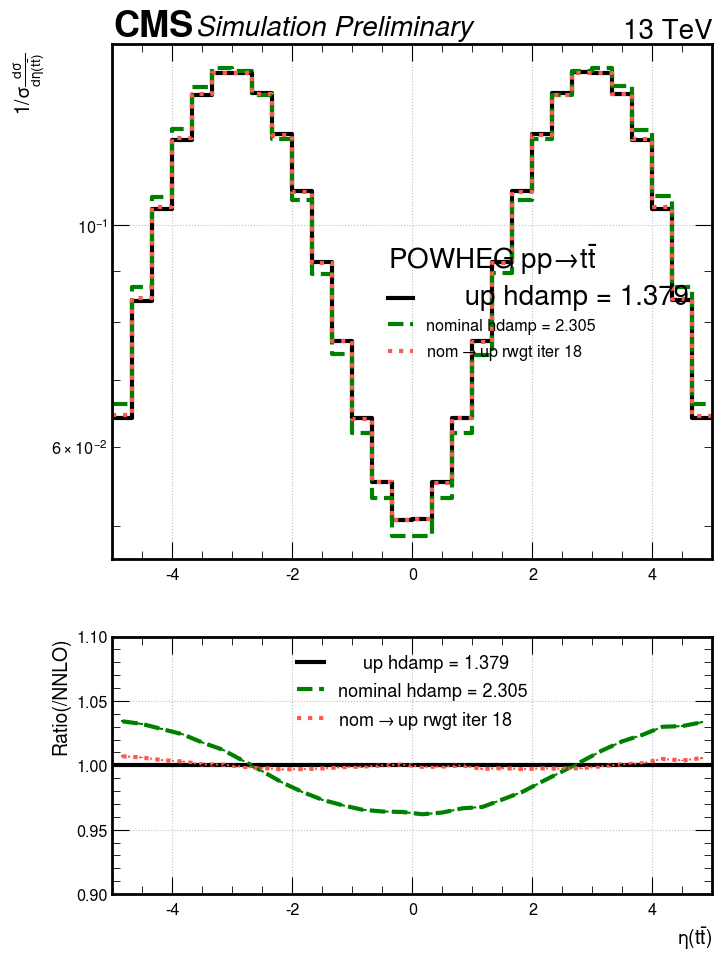

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 18: chi2, mae, 
 6.812797194664685, 3949.844846645228 



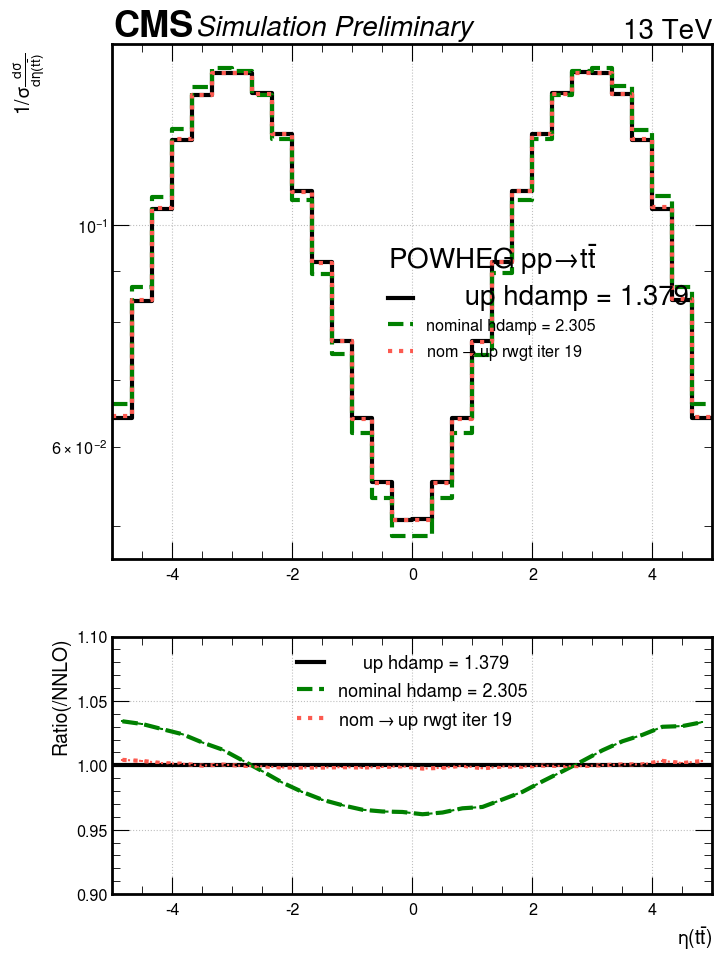

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 19: chi2, mae, 
 2.4339868441586954, 2261.50522768545 



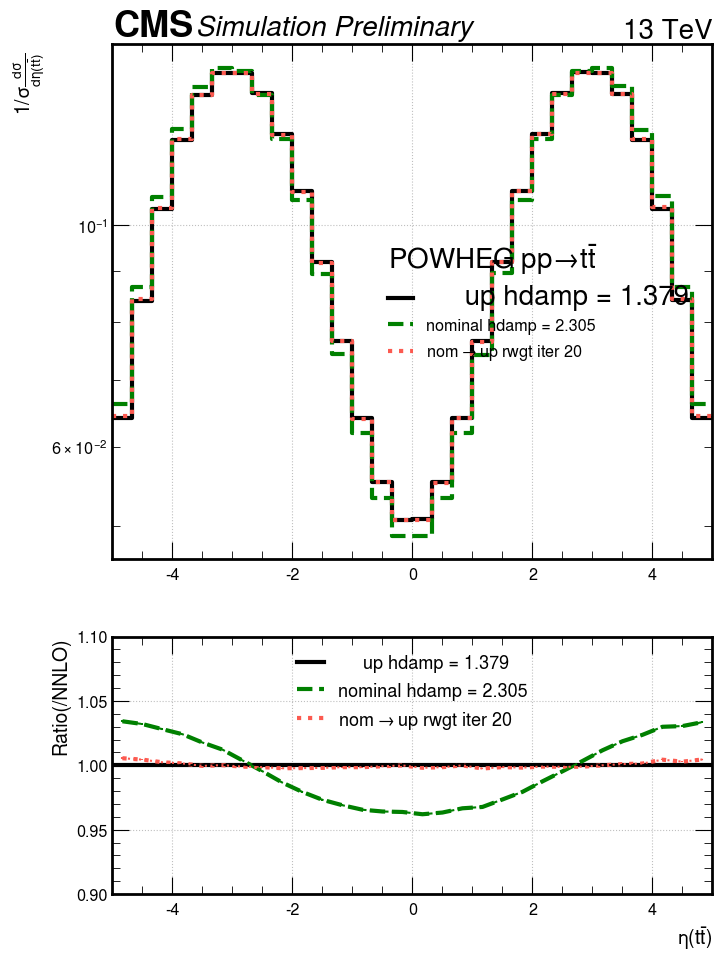

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 20: chi2, mae, 
 4.043939378129052, 3103.2873448140917 



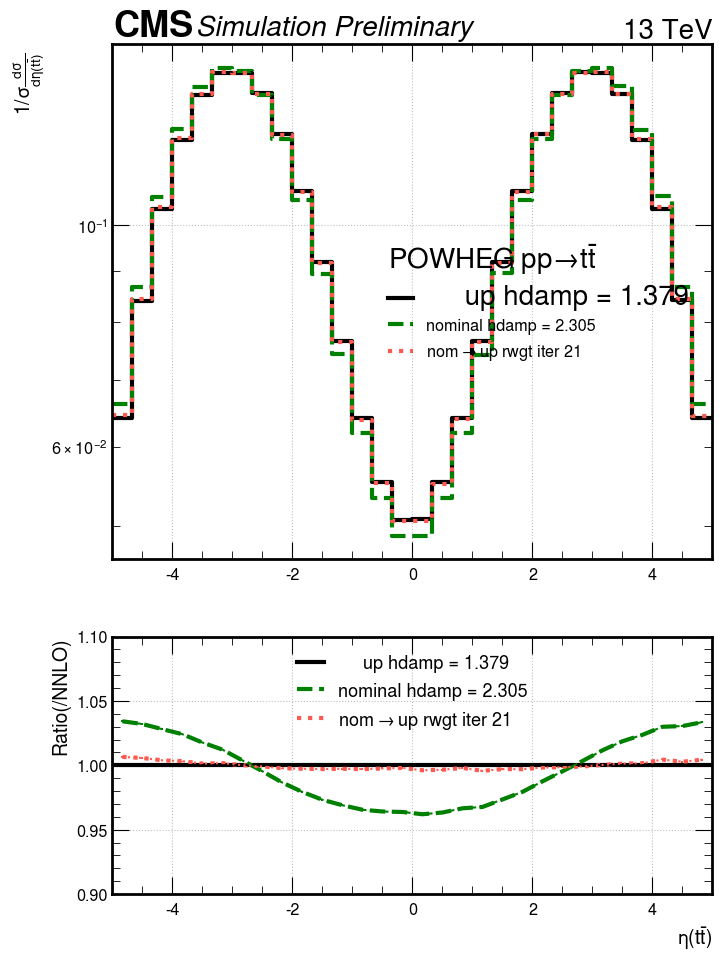

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 21: chi2, mae, 
 5.210720753850212, 3227.576668991542 



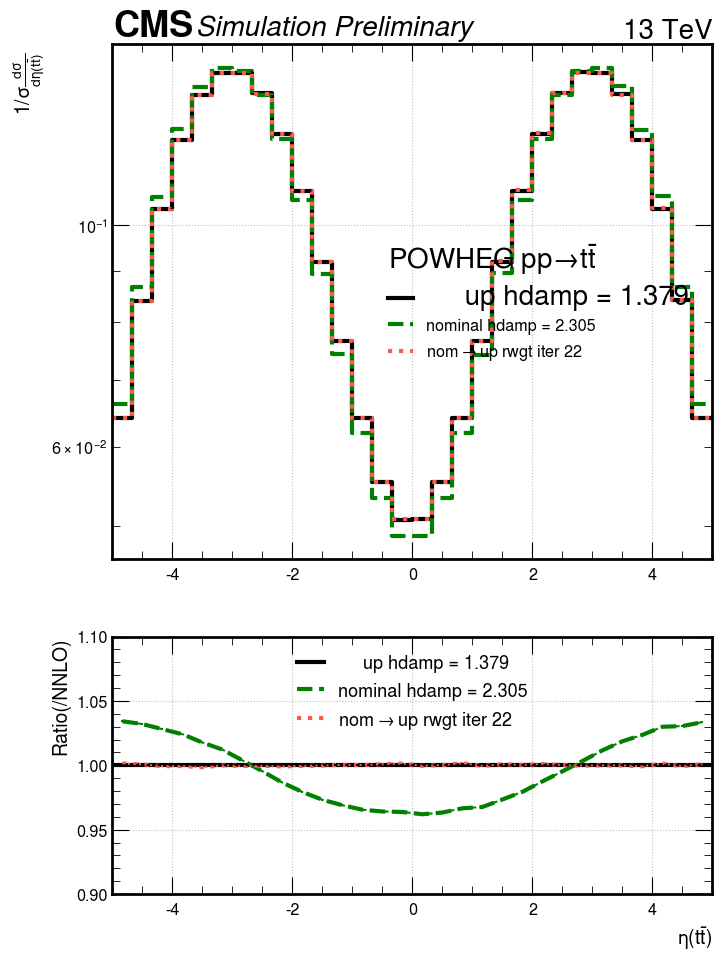

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 22: chi2, mae, 
 1.553308063384134, 978.7118020420613 



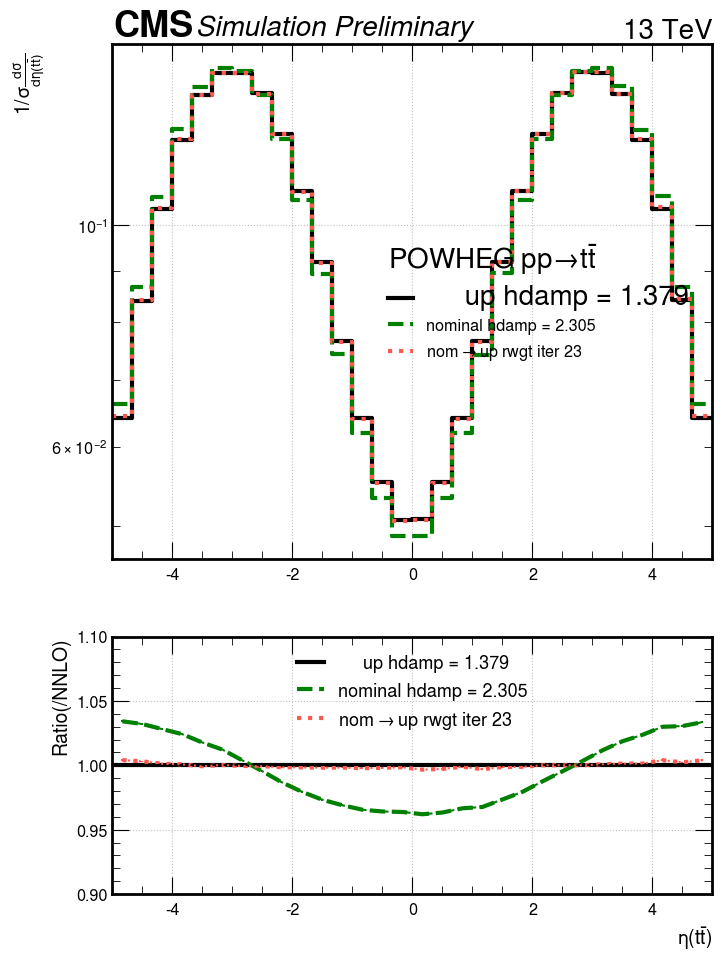

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 23: chi2, mae, 
 3.583468037527579, 3139.44989655688 



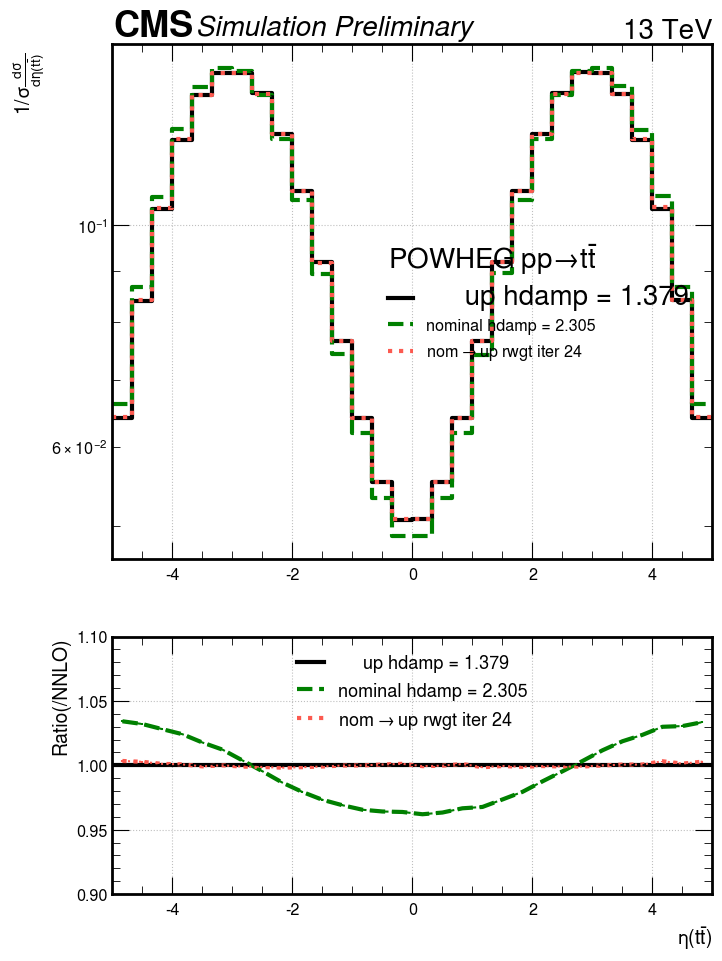

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 24: chi2, mae, 
 2.301874438334466, 1895.5737907770667 



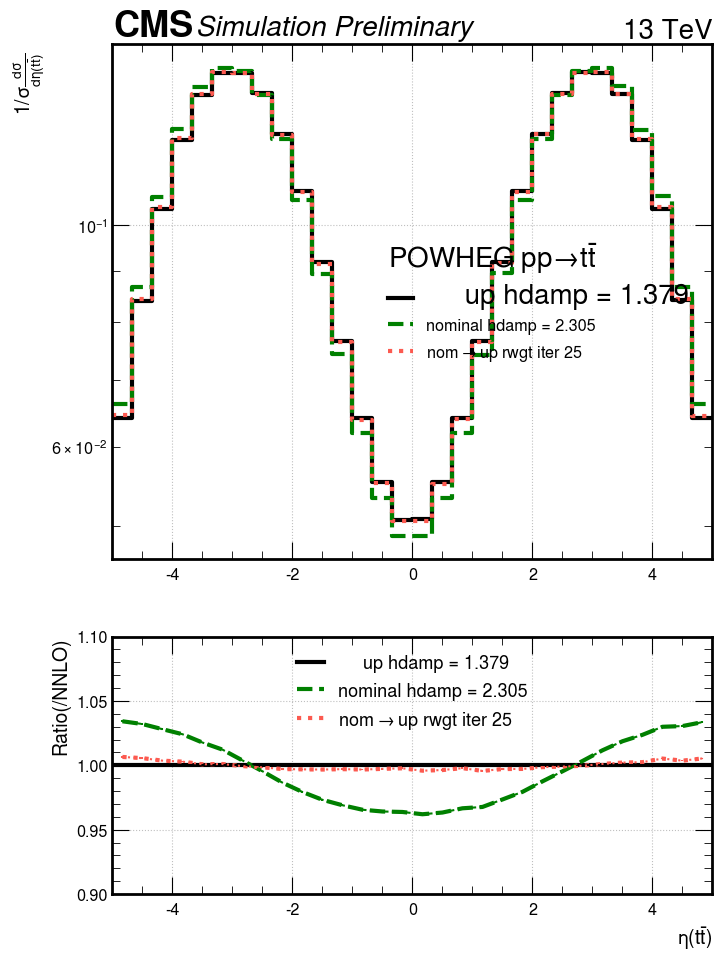

/tf/home/DCTR_Paper/DCTR_FP/20240607_bootstrapping/../20240503/DCTR.py:1185: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))



 iteration 25: chi2, mae, 
 6.38181638466396, 4424.8313978181 



In [158]:
# tt-pair eta
chi2_all = []
mae_all  = []

for i, wgts in enumerate(wgts_list):
    # setup args for plotting
    args = [(X0_plot[:,2], X0_plot_wgt, '     up hdamp = 1.379 '),
            (X1_plot[:,2], X1_plot_wgt, 'nominal hdamp = 2.305'),
            (X1_plot[:,2], wgts,      fr'nom$\rightarrow$up rwgt iter {i + 1}')]
    
    bins = np.linspace(-5, 5, 31)
    DCTR.plot_ratio_cms(args, bins = bins, y_scale='log', ratio_ylim=[0.9, 1.1], save_prefix = f'iter_{i+1:02d}',
                        part_label=r't\bar{t}', arg_label=r'\eta', unit=r' ', inv_unit=r' ')
    # stats
    mae_list, chi2_list, p_list = DCTR.plot_ratio(args, bins = log_bins, stats_only = True, verbose=False)
    
    # last element is the one we're interested in, the others are the baseline nom and up
    print(f'\n iteration {i + 1}: chi2, mae, \n {chi2_list[-1]}, {mae_list[-1]} \n')

    chi2_all.append(chi2_list[-1])
    mae_all.append(mae_list[-1])


In [159]:
# eta(tt) bins = np.linspace(-5, 5, 31)

chi2_all = np.array(chi2_all)
mae_all = np.array(mae_all)

print(f'{chi2_all = }\n')
print(f'{mae_all = }\n')

min_chi2  = np.min(chi2_all)
max_chi2  = np.max(chi2_all)
mean_chi2 = np.mean(chi2_all)
std_chi2  = np.std(chi2_all)

min_mae   = np.min(mae_all)
max_mae   = np.max(mae_all)
mean_mae  = np.mean(mae_all)
std_mae   = np.std(mae_all)

print(f'chi2: min, max, mean, std\n\
{min_chi2:5f}, {max_chi2:5f}, {mean_chi2:5f}, {std_chi2:5f}\n')

print(f'mae : min, max, mean, std\n\
{min_mae:5f}, {max_mae:5f}, {mean_mae:5f}, {std_mae:5f}\n')



chi2_all = array([ 3.407,  6.56 ,  4.375,  3.5  , 11.237,  4.239,  6.476,  1.912,
        8.683,  2.302,  3.329,  2.01 ,  4.138,  5.084,  6.761,  2.018,
        2.287,  6.813,  2.434,  4.044,  5.211,  1.553,  3.583,  2.302,
        6.382])

mae_all = array([3233.077, 4658.878, 3521.916, 2579.347, 6284.04 , 2905.572,
       4551.873, 1873.791, 4840.36 , 1776.47 , 2683.626, 1808.693,
       3023.951, 3892.532, 4593.319, 1565.574, 1191.515, 3949.845,
       2261.505, 3103.287, 3227.577,  978.712, 3139.45 , 1895.574,
       4424.831])

chi2: min, max, mean, std
1.553308, 11.236522, 4.425564, 2.342109

mae : min, max, mean, std
978.711802, 6284.040287, 3118.612685, 1285.404469

